# An ensemble experiment to be completed as of Nov 9th.

In [ ]:
import pandas as pd
import numpy as np
import h5py
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler
import tensorflow as tf

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import random

random.seed(42)

# Get Data and Preprocess for the model

In [ ]:
Xy_train = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_train_2000nosenti.csv')
Xy_val = pd.read_csv('/content/gdrive/MyDrive/lazard/preprocessed_data/Xy_val_2000nosenti.csv')
LOOKBACK = 60

In [ ]:
Xy_train.isna().sum().sum()

0

In [ ]:
Xy_val.isna().sum().sum()

0

In [ ]:
Xy_train.head()

date_x      Open      High       Low     Close  Adj Close     Volume  \
0  2000-02-29  3.300000  3.448438  3.293750  3.443750   3.443750  142970000   
1  2000-03-01  3.381250  3.425000  3.250000  3.293750   3.293750  111534000   
2  2000-03-02  3.246875  3.250000  3.109375  3.128125   3.128125  159602000   
3  2000-03-03  3.162500  3.237500  3.103125  3.125000   3.125000  121190000   
4  2000-03-06  3.143750  3.362500  3.140625  3.196875   3.196875  153316000   

         security    month  TRAIL_12M_NET_SALES  ...  \
0  AMZN US Equity  2000-02              1639.84  ...   
1  AMZN US Equity  2000-03              1920.08  ...   
2  AMZN US Equity  2000-03              1920.08  ...   
3  AMZN US Equity  2000-03              1920.08  ...   
4  AMZN US Equity  2000-03              1920.08  ...   

   lag1_MONTHLY_RETURN_F1_log  lag1_ma5_MONTHLY_RETURN_F1  \
0                   -3.045875                    0.015022   
1                   -3.045875                    0.015022   
2                   -3.045875                    0.015022   
3                   -3.045875                    0.015022   
4                   -3.045875                    0.015022   

   lag1_ma10_MONTHLY_RETURN_F1  lag1_ma15_MONTHLY_RETURN_F1  \
0                     0.015208                     0.015524   
1                     0.015208                     0.015524   
2                     0.015208                     0.015524   
3                     0.015208                     0.015524   
4                     0.015208                     0.015524   

   lag1_RSI_MONTHLY_RETURN_F1  lag1_MACD_MONTHLY_RETURN_F1  \
0                    49.76984                    -0.001494   
1                    49.76984                    -0.001494   
2                    49.76984                    -0.001494   
3                    49.76984                    -0.001494   
4                    49.76984                    -0.001494   

   lag1_MACD_signal_MONTHLY_RETURN_F1      date_y  MONTHLY_RETURN  \
0                           -0.000763  2000-02-29        0.066787   
1                           -0.000763  2000-03-31       -0.027223   
2                           -0.000763  2000-03-31       -0.027223   
3                           -0.000763  2000-03-31       -0.027223   
4                           -0.000763  2000-03-31       -0.027223   

   MONTHLY_RETURN_F1  
0          -0.027223  
1          -0.176299  
2          -0.176299  
3          -0.176299  
4          -0.176299  

[5 rows x 93 columns]

In [ ]:
FINAL_FEATURES = []
for col in list(Xy_train.columns):
  if col != 'security' and col != 'date_x' and col !=  'month' and col != 'date_y' and col != 'MONTHLY_RETURN' and col !=  'MONTHLY_RETURN_F1':
    FINAL_FEATURES.append(col)

In [ ]:
FINAL_FEATURES

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'TRAIL_12M_NET_SALES',
 'TRAIL_12M_EPS',
 'TRAIL_12M_OPER_MARGIN',
 'EV_TO_T12M_EBITDA',
 'ENTERPRISE_VALUE',
 'BEST_PE_RATIO',
 'PX_LAST',
 'BEST_SALES',
 'BEST_EPS',
 'BEST_CUR_EV_TO_EBITDA',
 'TRAIL_12M_EBITDA',
 'CUR_MKT_CAP',
 'VOLUME',
 'TRAIL_12M_GROSS_MARGIN',
 'EBIT_MARGIN',
 'BEST_LTG_EPS',
 'IS_DIV_PER_SHR',
 'EBITDA_MARGIN',
 'TOT_DEBT_TO_TOT_ASSET',
 'SALES_GROWTH',
 'EPS_GROWTH',
 'SALES_TO_CASH',
 'CURRENT_EV_TO_T12M_EBITDA',
 'PE_RATIO',
 'EQY_SH_OUT',
 'SHORT_INT',
 'SI_PERCENT_EQUITY_FLOAT',
 'RSK_BB_IMPLIED_CDS_SPREAD',
 'IVOL_DELTA',
 'OPEN_INT_TOTAL_CALL',
 'OPEN_INT_TOTAL_PUT',
 'PX_TO_BOOK_RATIO',
 'TOT_DEBT_TO_TOT_EQY',
 'TOT_DEBT_TO_EBITDA',
 'RETURN_COM_EQY',
 'TANG_BOOK_VAL_PER_SH',
 'NET_DEBT',
 'BEST_EBITDA',
 'TRAIL_12M_OPER_INC',
 'TRAIL_12M_CAP_EXPEND',
 'FREE_CASH_FLOW_YIELD',
 'TRAIL_12M_FREE_CASH_FLOW_PER_SH',
 'daily_return',
 'price_diff',
 'roc_vol',
 'ma5_close',
 'close_vs_ema5',
 'vol

In [ ]:
def get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return 1 set of split df for all stocks. But do the sliding window within each security
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  securities = list(Xy_train.security.unique())
  X_train = []
  y_train = []
  X_val = []
  y_val = []
  tdates = []
  vdates = []
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    train_dates =  Xy_train[Xy_train['security']==security]['date_x']
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    val_dates =  Xy_val[Xy_val['security']==security]['date_x']
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)


    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        X_train.append(train_stock_scaled[i - LOOKBACK:i, :-1])
        y_train.append(train_stock_scaled[i, -1])
        tdates.append(train_dates.iloc[i])

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        X_val.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        y_val.append(val_stock_scaled[i, -1])
        vdates.append(val_dates.iloc[i])


  X_train, y_train = np.array(X_train),np.array(y_train)
  X_val, y_val = np.array(X_val),np.array(y_val)
  stocks = {} # a dict : {'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  stocks['X_train'] = X_train
  stocks['y_train'] = y_train
  stocks['X_val'] = X_val
  stocks['y_val'] = y_val
  stocks['val_dates'] = np.array(vdates)
  stocks['train_dates'] = np.array(tdates)
  print(f'X_train shape :{X_train.shape}, y_train shape:{y_train.shape}; X_val shape :{X_val.shape}, y_val shape:{y_val.shape}, val_dates shape: {np.array(vdates).shape}, train_dates shape: {np.array(tdates).shape}')
  return stocks



In [ ]:
def get_data(Xy_train, Xy_val, LOOKBACK, task, features):
  """
  return X,y seperately for all 25 stocks.
  stock25 = {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
    Note: for LSTM the X_train and y_train contains a 3D matrix (samples, window_span, features); y_train and y_val are (sample,)
  """
  # organize features
  if task == 'current':
    f = features.copy()
    f.append('MONTHLY_RETURN')
  else:
    f = features.copy()
    f.append('MONTHLY_RETURN_F1')

  print(f"TASK:{task}")
  stocks25 = {} # a dict of dicts : {'security1':{'X_train':data, 'X_val':data, 'y_train':data', 'X_test':data}}
  securities = list(Xy_train.security.unique())
  for security in securities:
    # train
    train_stock = Xy_train[Xy_train['security']==security][f].values # take sure columns are int he right order
    train_dates =  Xy_train[Xy_train['security']==security]['date_x']
    if len(train_stock) == 0:
        print(f'Error, size of train stock {security} =0')
        return
    scalar_stock_train = StandardScaler()
    train_stock_scaled = scalar_stock_train.fit_transform(train_stock)

    # validation
    val_stock = Xy_val[Xy_val['security']==security][f].values
    val_dates =  Xy_val[Xy_val['security']==security]['date_x']
    if len(val_stock) == 0:
        print(f'Error, size of val stock {security} =0')
        return
    scalar_stock_val = StandardScaler()
    val_stock_scaled = scalar_stock_val.fit_transform(val_stock)

    X_train_stock = []
    y_train_stock = []
    X_val_stock = []
    y_val_stock = []
    tdates = []
    vdates = []

    # train
    for i in range(LOOKBACK, len(train_stock_scaled)):
        X_train_stock.append(train_stock_scaled[i - LOOKBACK:i, :-1]) #
        y_train_stock.append(train_stock_scaled[i, -1]) # last column in Xy_train as y_train
        tdates.append(train_dates.iloc[i])

    X_train_stock, y_train_stock = np.array(X_train_stock),np.array(y_train_stock)

    # validation
    for i in range(LOOKBACK, len(val_stock_scaled)):
        X_val_stock.append(val_stock_scaled[i - LOOKBACK:i, :-1])
        y_val_stock.append(val_stock_scaled[i, -1])
        vdates.append(val_dates.iloc[i])

    X_val_stock, y_val_stock = np.array(X_val_stock),np.array(y_val_stock)

    print(f'{security}: X_train shape :{X_train_stock.shape}, y_train shape:{y_train_stock.shape}; X_val shape :{X_val_stock.shape}, y_val shape:{y_val_stock.shape}, , val_dates shape: {np.array(vdates).shape}, train_dates shape: {np.array(tdates).shape}')

    stock_og = {}
    stock_og['X_train'] = X_train_stock
    stock_og['y_train'] = y_train_stock
    stock_og['X_val'] = X_val_stock
    stock_og['y_val'] = y_val_stock
    stock_og['val_dates'] = np.array(vdates)
    stock_og['train_dates'] = np.array(tdates)
    stocks25[security] = stock_og

  return stocks25



In [ ]:
stock25_cur = get_data(Xy_train, Xy_val, LOOKBACK, 'current', FINAL_FEATURES)
stock25_next = get_data(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
AMZN US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,), , val_dates shape: (1133,), train_dates shape: (4661,)
APTV US Equity: X_train shape :(2267, 60, 87), y_train shape:(2267,); X_val shape :(548, 60, 87), y_val shape:(548,), , val_dates shape: (548,), train_dates shape: (2267,)
AZO US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,), , val_dates shape: (1133,), train_dates shape: (4661,)
BKNG US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,), , val_dates shape: (1133,), train_dates shape: (4661,)
CCL US Equity: X_train shape :(4661, 60, 87), y_train shape:(4661,); X_val shape :(1133, 60, 87), y_val shape:(1133,), , val_dates shape: (1133,), train_dates shape: (4661,)
CMG US Equity: X_train shape :(3446, 60, 87), y_train shape:(3446,); X_val shape :(841, 60, 87), y_val shape:(841,), 

In [ ]:
stock_ONE_curv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK,  'current',FINAL_FEATURES)
stock_ONE_nextv1 = get_ONE_datav1(Xy_train, Xy_val, LOOKBACK, 'next',FINAL_FEATURES)

TASK:current
X_train shape :(104981, 60, 87), y_train shape:(104981,); X_val shape :(25463, 60, 87), y_val shape:(25463,), val_dates shape: (25463,), train_dates shape: (104981,)
TASK:next
X_train shape :(104981, 60, 87), y_train shape:(104981,); X_val shape :(25463, 60, 87), y_val shape:(25463,), val_dates shape: (25463,), train_dates shape: (104981,)


# Modeling

In [ ]:
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr), loss='mean_squared_error')
    return model

In [ ]:
def train_aggregate_model(train_df = None, val_df = None, task = None, N_epoch = 30):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']

  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  #assert single_day_feature_dim == 90

  stock_model = create_model(single_day_feature_dim, 0.01)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=32)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model2000.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']
    stock_val_dates = val['val_dates']


    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val, 'val_dates': stock_val_dates}
    pred25[key]=pred_org

  return pred25

In [ ]:
def analyze(pred25_cur, TASK, mode):
    """
    generate prediction vs y_true plot
    save evaluation metrics to path.
    """
    # Iterate over each stock in the dictionary
    for stock_name, predictions in pred25_cur.items():
        y_preds = predictions['y_preds']
        y = predictions['y']
        y_dates = predictions['val_dates']


        # Create a figure and axis
        fig, ax = plt.subplots()
        print(f'y vs y_pred: {y.shape} vs {y_preds.shape}')


        # Plot the real returns (y) in blue
        ax.plot(y_dates, y, label='Real Returns', color='blue')

        # Plot the predicted returns (y_preds) in red
        ax.plot(y_dates, y_preds, label='Predicted Returns', color='red')

        # Set axis labels and a legend
        ax.set_xlabel('Time')
        ax.set_ylabel('Returns')
        ax.set_title(f'{stock_name} - Real vs. Predicted Returns')
        ax.legend()

        # Display or save the plot as needed
        plt.show()  # Use
        #plot_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_nocomp.png'
        #plt.savefig(plot_path) # to save the plot to a file

    pred25_cur = pd.DataFrame(pred25_cur)
    analysis_path = f'/content/gdrive/MyDrive/lazard/models/task_{TASK}/outputs/{mode}LSTM_{TASK}_lr0.01_comp.csv'
    pred25_cur.to_csv(analysis_path)
    return pred25_cur




## Task : predict 'MONTHLY_RETURN'

### One model all stock

In [ ]:
TASK = 'current'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

mode = 'agg'

pred25_aggregate_cur = train_aggregate_model(train_df = dfall, val_df = df25, task = TASK, N_epoch = 7)

Epoch 1/7
2625/2625 [==============================] - ETA: 0s - loss: 0.2856
Epoch 1: val_loss improved from inf to 0.18139, saving model to weights_task_current_aggregate_model.h5
2625/2625 [==============================] - 48s 14ms/step - loss: 0.2856 - val_loss: 0.1814 - lr: 0.0100
Epoch 2/7
2621/2625 [============================>.] - ETA: 0s - loss: 0.2086
Epoch 2: val_loss did not improve from 0.18139
2625/2625 [==============================] - 34s 13ms/step - loss: 0.2085 - val_loss: 0.1932 - lr: 0.0100
Epoch 3/7
2623/2625 [============================>.] - ETA: 0s - loss: 0.1968
Epoch 3: val_loss did not improve from 0.18139
2625/2625 [==============================] - 34s 13ms/step - loss: 0.1968 - val_loss: 0.2374 - lr: 0.0100
Epoch 4/7
2621/2625 [============================>.] - ETA: 0s - loss: 0.1942
Epoch 4: val_loss did not improve from 0.18139
2625/2625 [==============================] - 33s 13ms/step - loss: 0.1942 - val_loss: 0.1832 - lr: 0.0100
Epoch 5/7
2624/2625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
36/36 [==============================] - 1s 7ms/step


-------------------APTV US Equity--------------------
18/18 [==============================] - 0s 5ms/step


-------------------AZO US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------BKNG US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------CCL US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------CMG US Equity--------------------
27/27 [==============================] - 0s 5ms/step


-------------------DG US Equity--------------------
20/20 [==============================] - 0s 5ms/step


-------------------EBAY US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------F US Equity--------------------
36/36 [==============================] - 0s 5ms/step


-------------------GM US 

y vs y_pred: (1133,) vs (1133, 1)


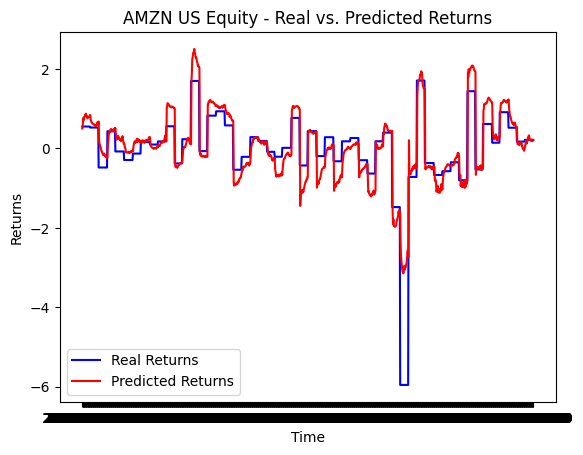

y vs y_pred: (548,) vs (548, 1)


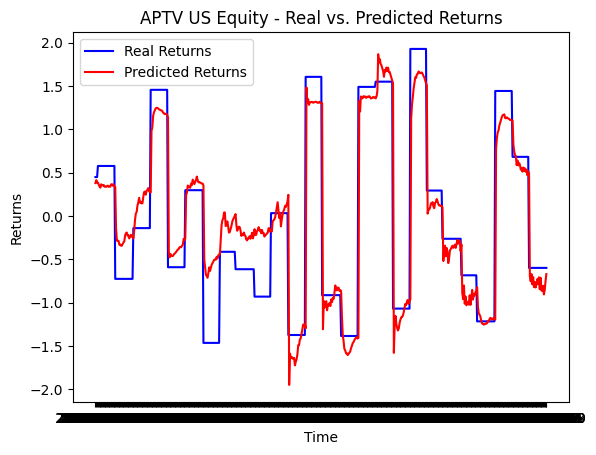

y vs y_pred: (1133,) vs (1133, 1)


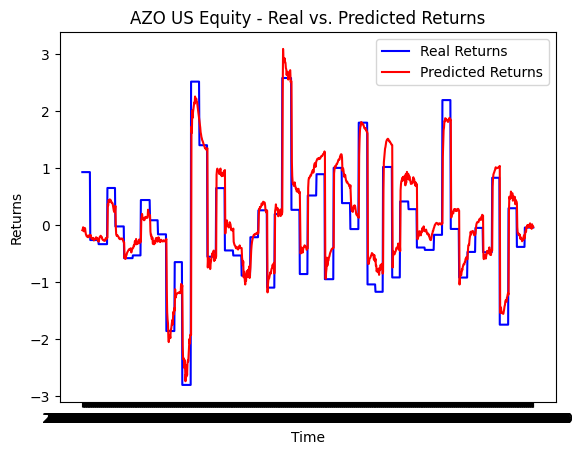

y vs y_pred: (1133,) vs (1133, 1)


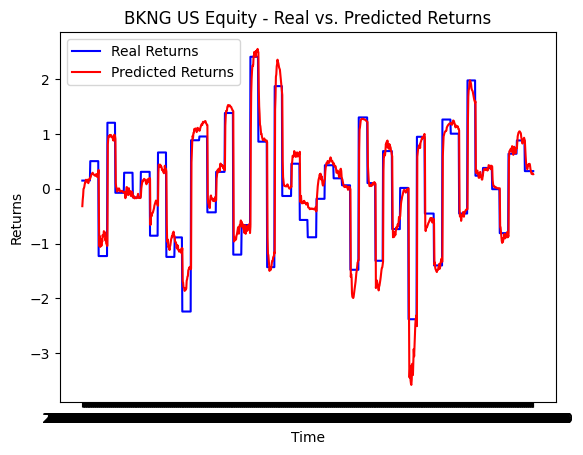

y vs y_pred: (1133,) vs (1133, 1)


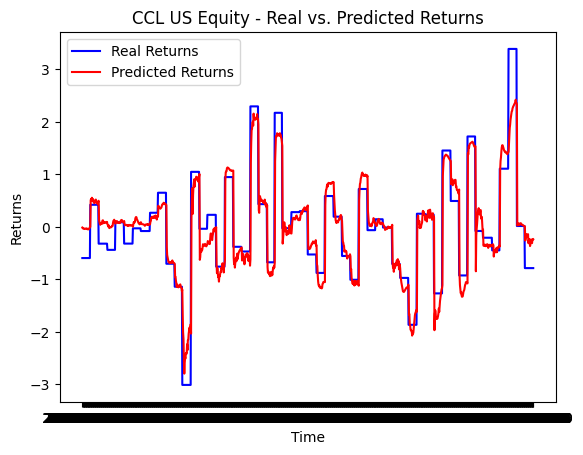

y vs y_pred: (841,) vs (841, 1)


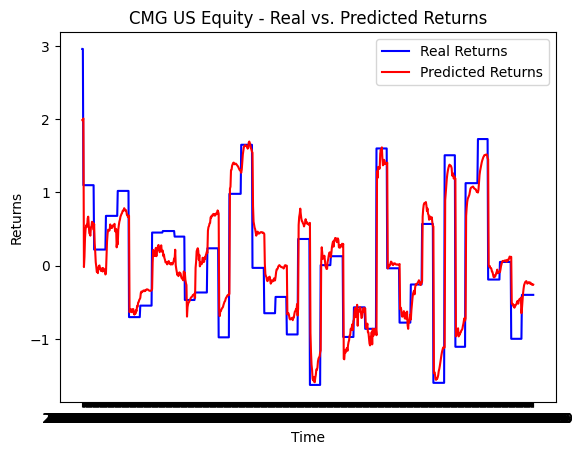

y vs y_pred: (631,) vs (631, 1)


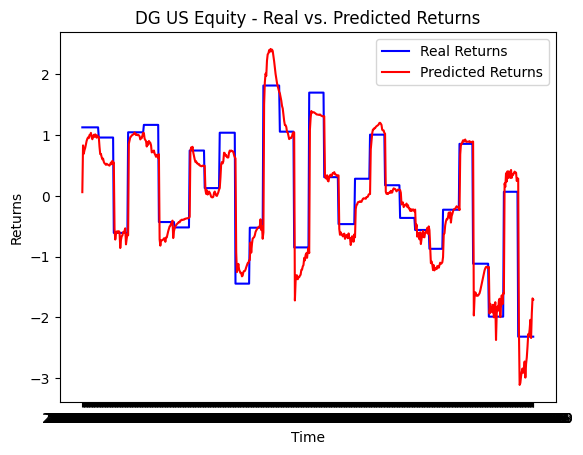

y vs y_pred: (1133,) vs (1133, 1)


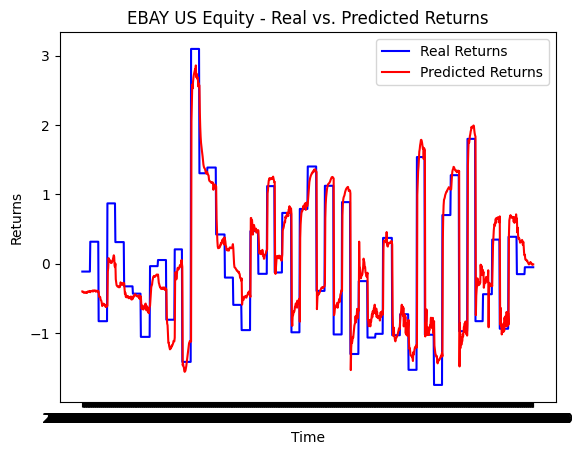

y vs y_pred: (1133,) vs (1133, 1)


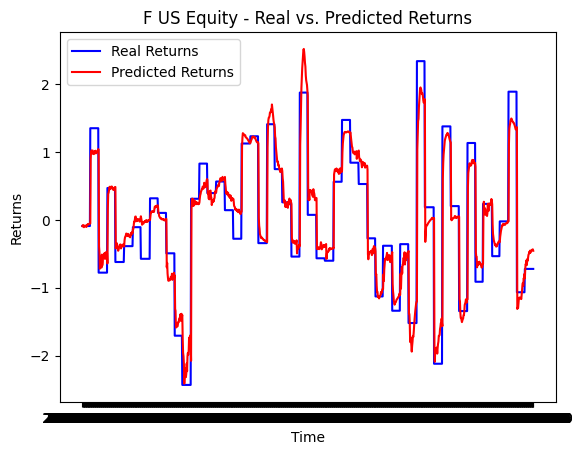

y vs y_pred: (590,) vs (590, 1)


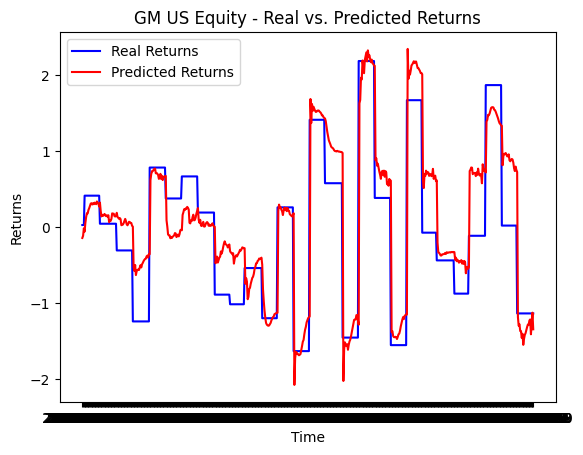

y vs y_pred: (1133,) vs (1133, 1)


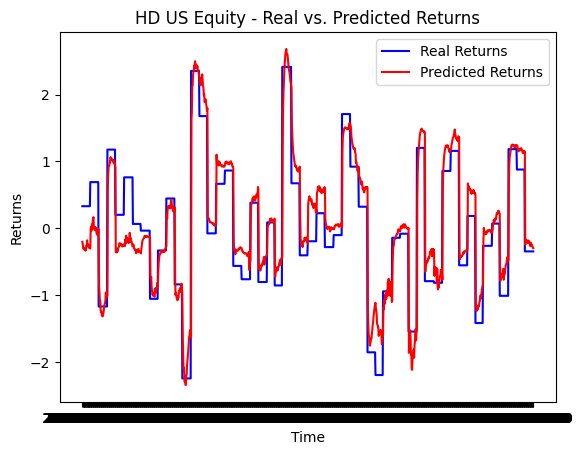

y vs y_pred: (442,) vs (442, 1)


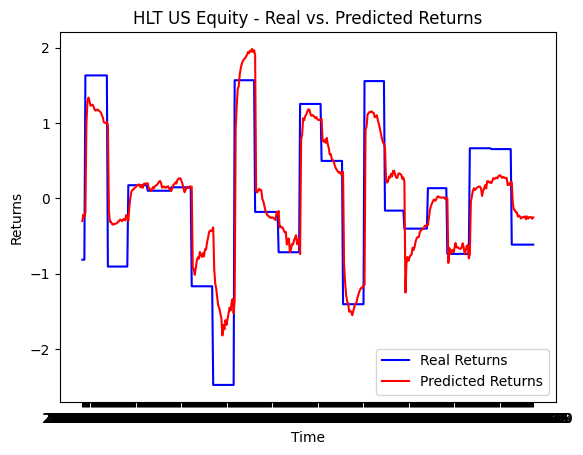

y vs y_pred: (1133,) vs (1133, 1)


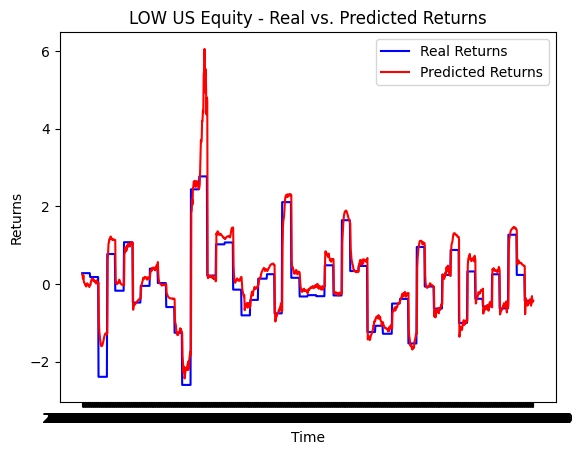

y vs y_pred: (883,) vs (883, 1)


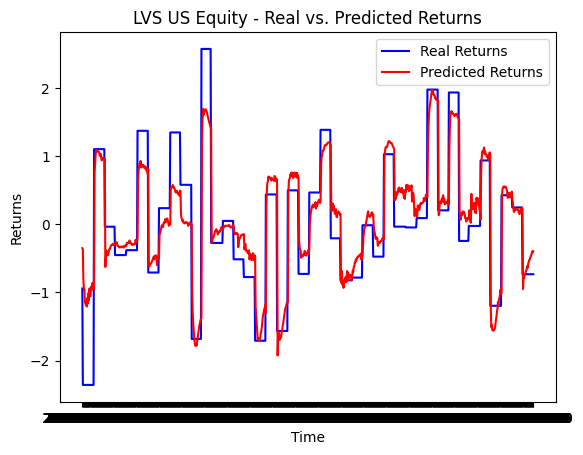

y vs y_pred: (1133,) vs (1133, 1)


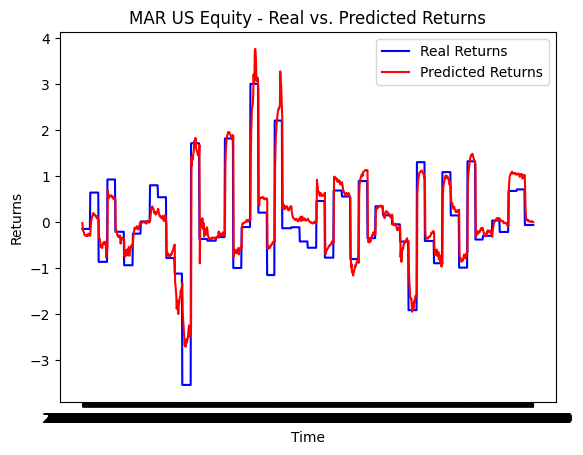

y vs y_pred: (1133,) vs (1133, 1)


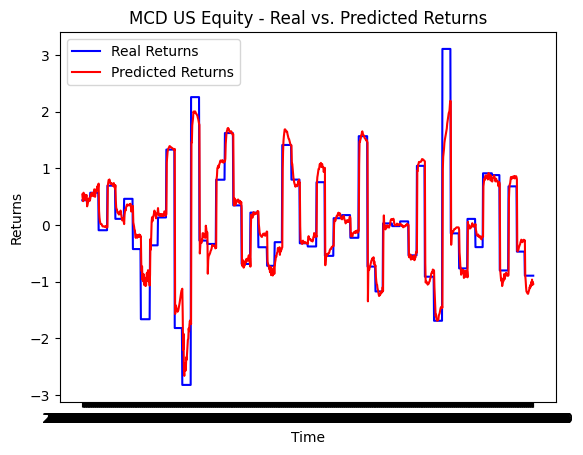

y vs y_pred: (1133,) vs (1133, 1)


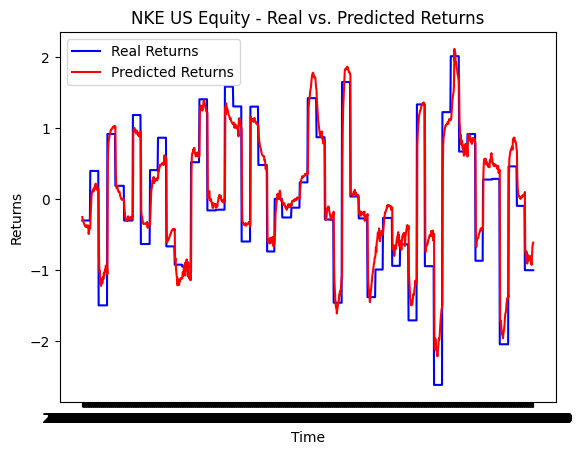

y vs y_pred: (1133,) vs (1133, 1)


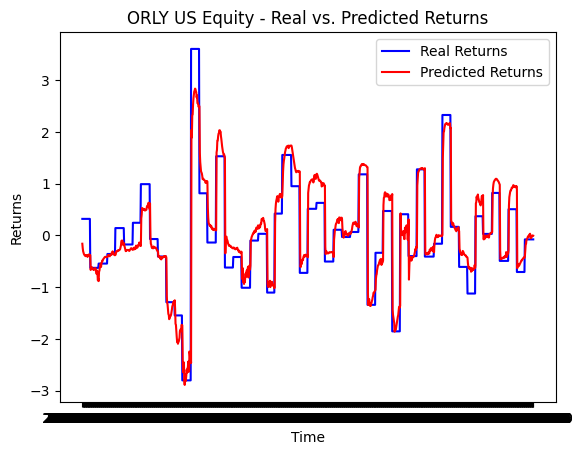

y vs y_pred: (1133,) vs (1133, 1)


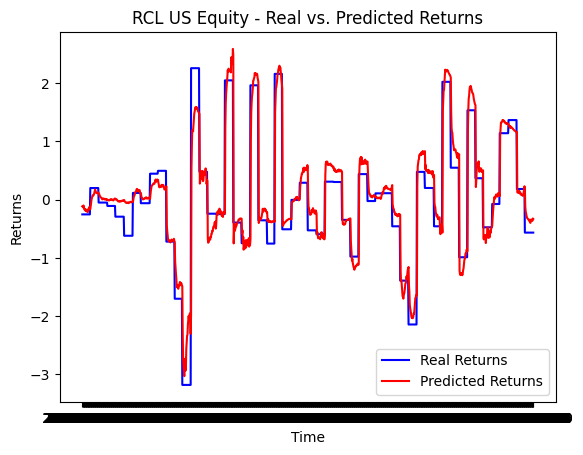

y vs y_pred: (1133,) vs (1133, 1)


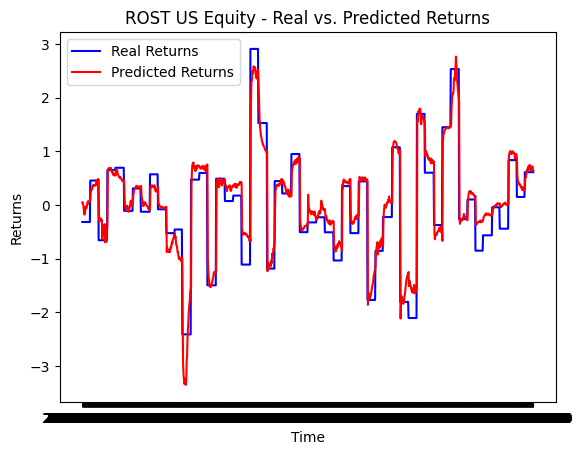

y vs y_pred: (1133,) vs (1133, 1)


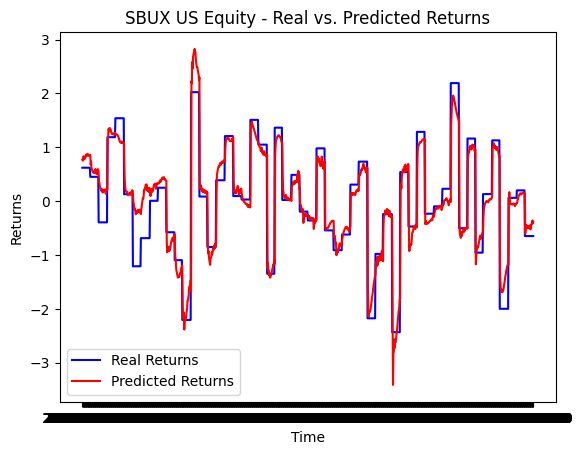

y vs y_pred: (1133,) vs (1133, 1)


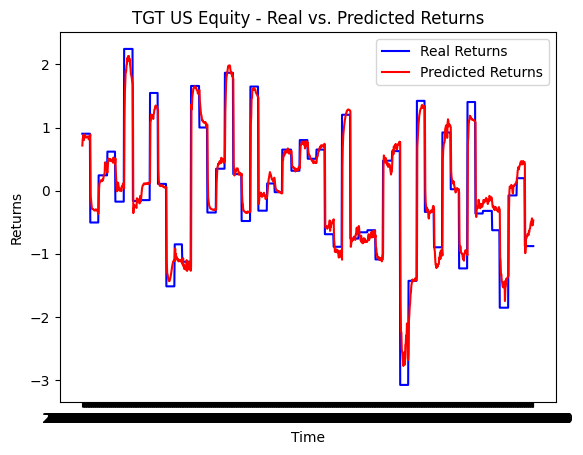

y vs y_pred: (1133,) vs (1133, 1)


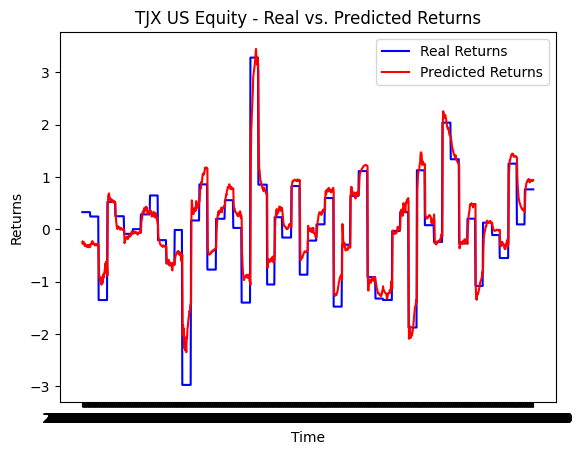

y vs y_pred: (1133,) vs (1133, 1)


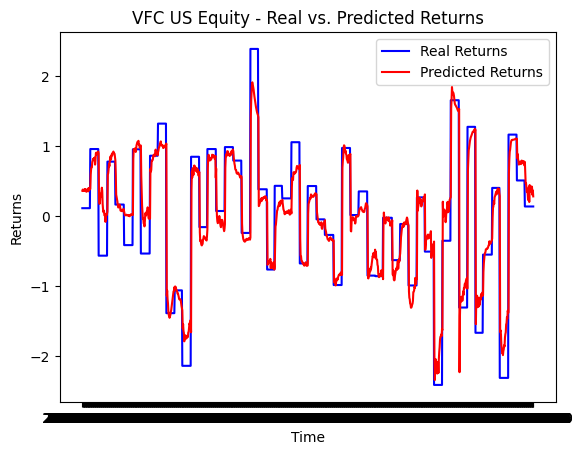

y vs y_pred: (1134,) vs (1134, 1)


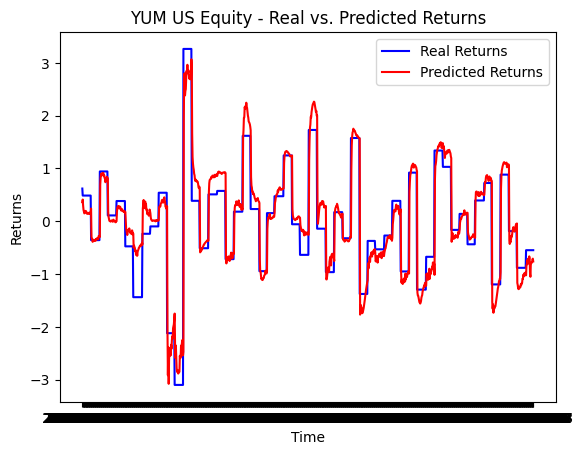

In [ ]:
pred25_aggregate_cur = analyze(pred25_aggregate_cur, TASK, mode)


In [ ]:
pred25_aggregate_cur

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.698489   
rmse                                                         0.556707   
mse                                                          0.309922   
y_preds             [[0.5031197], [0.5581381], [0.7626445], [0.706...   
y                   [0.5519601998264473, 0.5519601998264473, 0.551...   
val_dates           [2019-03-04, 2019-03-05, 2019-03-06, 2019-03-0...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.803967   
rmse                                                         0.461407   
mse                                                          0.212896   
y_preds             [[0.3789333], [0.41306627], [0.38431433], [0.3...   
y                   [0.4487308187640146, 0.4487308187640146, 0.448...   
val_dates           [2021-06-28, 2021-06-29, 2021-06-30, 2021-07-0...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.804897   
rmse                                                         0.447788   
mse                                                          0.200514   
y_preds             [[-0.08868158], [-0.0736779], [-0.03657943], [...   
y                   [0.9301083786080782, 0.9301083786080782, 0.930...   
val_dates           [2019-03-04, 2019-03-05, 2019-03-06, 2019-03-0...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.827819   
rmse                                                         0.418183   
mse                                                          0.174877   
y_preds             [[-0.31865698], [-0.20023453], [-0.12612534], ...   
y                   [0.14869374547027558, 0.14869374547027558, 0.1...   
val_dates           [2019-03-04, 2019-03-05, 2019-03-06, 2019-03-0...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.824676   
rmse                                                         0.424072   
mse                                                          0.179837   
y_preds             [[-0.011581123], [-0.027135015], [-0.026548088...   
y                   [-0.5926962172529414, -0.5926962172529414, -0....   
val_dates           [2019-03-04, 2019-03-05, 2019-03-06, 2019-03-0...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.791626   
rmse                                                         0.399614   
mse                                                          0.159691   
y_preds             [[1.9898746], [1.9942687], [2.0124002], [-0.01...   
y                   [2.961901351418715, 2.961901351418715, 1.09997...   
val_dates           [2020-04-29, 2020-04-30, 2020-05-01, 2020-05-0...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_cur...   
r_squared_adjusted                                           0.859438   
rmse                                                         0.386493   
mse                                                          0.149377   
y_preds             [[0.060367733], [0.82944036], [0.6922792], [0....   
y                   [1.1263811777176158, 1.1263811777176158, 1.126...   
val_dates           [2021-03-01, 2

In [ ]:
save_predictions(pred25_aggregate_cur, signature = 'LSTM_pricecf_2000/current/agg', note = 'epoch7')

## Task: predict 'MONTHLY_RETURN_F1'

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1

### Separate model each stock

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'sep'
pred25_next = run_model(df25, TASK) # run 25 separate models and evaluate



-------------------AMZN US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.2318
Epoch 1: val_loss improved from inf to 0.39314, saving model to weights_task_next_AMZN US Equity_model.h5
117/117 [==============================] - 9s 27ms/step - loss: 1.2283 - val_loss: 0.3931 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 1.1001
Epoch 2: val_loss did not improve from 0.39314
117/117 [==============================] - 2s 14ms/step - loss: 1.0926 - val_loss: 0.4970 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0636
Epoch 3: val_loss did not improve from 0.39314
117/117 [==============================] - 2s 14ms/step - loss: 1.0668 - val_loss: 0.4629 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 1.0902
Epoch 4: val_loss did not improve from 0.39314
117/117 [==============================] - 2s 14ms/step - loss: 1.0919 - val_los

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------APTV US Equity--------------------
Epoch 1/30
56/57 [============================>.] - ETA: 0s - loss: 0.8131
Epoch 1: val_loss improved from inf to 2.11388, saving model to weights_task_next_APTV US Equity_model.h5
57/57 [==============================] - 8s 36ms/step - loss: 0.8130 - val_loss: 2.1139 - lr: 0.0100
Epoch 2/30
56/57 [============================>.] - ETA: 0s - loss: 0.5661
Epoch 2: val_loss improved from 2.11388 to 2.10734, saving model to weights_task_next_APTV US Equity_model.h5
57/57 [==============================] - 1s 15ms/step - loss: 0.5634 - val_loss: 2.1073 - lr: 0.0100
Epoch 3/30
57/57 [==============================] - ETA: 0s - loss: 0.4469
Epoch 3: val_loss improved from 2.10734 to 2.02128, saving model to weights_task_next_APTV US Equity_model.h5
57/57 [==============================] - 1s 15ms/step - loss: 0.4469 - val_loss: 2.0213 - lr: 0.0100
Epoch 4/30
54/57 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 1s 5ms/step


-------------------AZO US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 0.9545
Epoch 1: val_loss improved from inf to 0.75960, saving model to weights_task_next_AZO US Equity_model.h5
117/117 [==============================] - 11s 25ms/step - loss: 0.9552 - val_loss: 0.7596 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 0.8996
Epoch 2: val_loss did not improve from 0.75960
117/117 [==============================] - 2s 14ms/step - loss: 0.8996 - val_loss: 0.7844 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.8758
Epoch 3: val_loss did not improve from 0.75960
117/117 [==============================] - 2s 14ms/step - loss: 0.8749 - val_loss: 0.8676 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.8379
Epoch 4: val_loss improved from 0.75960 to 0.71077, saving model to weights

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------BKNG US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.2102
Epoch 1: val_loss improved from inf to 0.13396, saving model to weights_task_next_BKNG US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.2094 - val_loss: 0.1340 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.0725
Epoch 2: val_loss improved from 0.13396 to 0.11838, saving model to weights_task_next_BKNG US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0701 - val_loss: 0.1184 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.9428
Epoch 3: val_loss did not improve from 0.11838
117/117 [==============================] - 2s 14ms/step - loss: 0.9409 - val_loss: 0.1243 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.7372
Epoch 4: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------CCL US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 1.0575
Epoch 1: val_loss improved from inf to 0.61934, saving model to weights_task_next_CCL US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0575 - val_loss: 0.6193 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.8916
Epoch 2: val_loss did not improve from 0.61934
117/117 [==============================] - 2s 14ms/step - loss: 0.8959 - val_loss: 1.0767 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 0.8408
Epoch 3: val_loss did not improve from 0.61934
117/117 [==============================] - 2s 14ms/step - loss: 0.8408 - val_loss: 0.8291 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.7995
Epoch 4: val_loss did not improve from 0.61934
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------CMG US Equity--------------------
Epoch 1/30
87/87 [==============================] - ETA: 0s - loss: 1.0382
Epoch 1: val_loss improved from inf to 0.96022, saving model to weights_task_next_CMG US Equity_model.h5
87/87 [==============================] - 8s 29ms/step - loss: 1.0382 - val_loss: 0.9602 - lr: 0.0100
Epoch 2/30
87/87 [==============================] - ETA: 0s - loss: 0.9779
Epoch 2: val_loss did not improve from 0.96022
87/87 [==============================] - 1s 14ms/step - loss: 0.9779 - val_loss: 1.2471 - lr: 0.0100
Epoch 3/30
86/87 [============================>.] - ETA: 0s - loss: 0.9533
Epoch 3: val_loss did not improve from 0.96022
87/87 [==============================] - 1s 15ms/step - loss: 0.9522 - val_loss: 0.9647 - lr: 0.0100
Epoch 4/30
87/87 [==============================] - ETA: 0s - loss: 0.8813
Epoch 4: val_loss improved from 0.96022 to 0.88620, saving model to weights_task_next_CMG 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 1s 5ms/step


-------------------DG US Equity--------------------
Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 1.1245
Epoch 1: val_loss improved from inf to 3.86185, saving model to weights_task_next_DG US Equity_model.h5
68/68 [==============================] - 8s 33ms/step - loss: 1.1245 - val_loss: 3.8619 - lr: 0.0100
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 0.8721
Epoch 2: val_loss improved from 3.86185 to 1.82847, saving model to weights_task_next_DG US Equity_model.h5
68/68 [==============================] - 1s 15ms/step - loss: 0.8733 - val_loss: 1.8285 - lr: 0.0100
Epoch 3/30
66/68 [============================>.] - ETA: 0s - loss: 0.7248
Epoch 3: val_loss did not improve from 1.82847
68/68 [==============================] - 1s 15ms/step - loss: 0.7235 - val_loss: 3.0353 - lr: 0.0100
Epoch 4/30
66/68 [============================>.] - ETA: 0s - loss: 0.5529
Epoch 4: val_loss did not impro

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 1s 5ms/step


-------------------EBAY US Equity--------------------
Epoch 1/30
117/117 [==============================] - ETA: 0s - loss: 1.1349
Epoch 1: val_loss improved from inf to 0.54814, saving model to weights_task_next_EBAY US Equity_model.h5
117/117 [==============================] - 11s 25ms/step - loss: 1.1349 - val_loss: 0.5481 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 1.0739
Epoch 2: val_loss improved from 0.54814 to 0.54385, saving model to weights_task_next_EBAY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0711 - val_loss: 0.5439 - lr: 0.0100
Epoch 3/30
113/117 [===========================>..] - ETA: 0s - loss: 1.0250
Epoch 3: val_loss improved from 0.54385 to 0.52615, saving model to weights_task_next_EBAY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0298 - val_loss: 0.5262 - lr: 0.0100
Epoch 4/30
116/117 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------F US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.2130
Epoch 1: val_loss improved from inf to 0.39983, saving model to weights_task_next_F US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.2022 - val_loss: 0.3998 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 1.0950
Epoch 2: val_loss improved from 0.39983 to 0.26956, saving model to weights_task_next_F US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 1.0850 - val_loss: 0.2696 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 1.0656
Epoch 3: val_loss did not improve from 0.26956
117/117 [==============================] - 2s 14ms/step - loss: 1.0815 - val_loss: 0.5735 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 1.0886
Epoch 4: val_loss di

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------GM US Equity--------------------
Epoch 1/30
59/62 [===========================>..] - ETA: 0s - loss: 0.7917
Epoch 1: val_loss improved from inf to 2.11986, saving model to weights_task_next_GM US Equity_model.h5
62/62 [==============================] - 8s 34ms/step - loss: 0.7816 - val_loss: 2.1199 - lr: 0.0100
Epoch 2/30
62/62 [==============================] - ETA: 0s - loss: 0.6532
Epoch 2: val_loss did not improve from 2.11986
62/62 [==============================] - 1s 15ms/step - loss: 0.6532 - val_loss: 2.5208 - lr: 0.0100
Epoch 3/30
61/62 [============================>.] - ETA: 0s - loss: 0.6149
Epoch 3: val_loss did not improve from 2.11986
62/62 [==============================] - 1s 14ms/step - loss: 0.6138 - val_loss: 2.5368 - lr: 0.0100
Epoch 4/30
61/62 [============================>.] - ETA: 0s - loss: 0.5638
Epoch 4: val_loss did not improve from 2.11986
62/62 [==============================] - 1s 1

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


19/19 [==============================] - 1s 5ms/step


-------------------HD US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.1311
Epoch 1: val_loss improved from inf to 0.50944, saving model to weights_task_next_HD US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.1284 - val_loss: 0.5094 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 1.0254
Epoch 2: val_loss improved from 0.50944 to 0.49851, saving model to weights_task_next_HD US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0237 - val_loss: 0.4985 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.9188
Epoch 3: val_loss improved from 0.49851 to 0.49774, saving model to weights_task_next_HD US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.9185 - val_loss: 0.4977 - lr: 0.0100
Epoch 4/30
114/117 [=============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------HLT US Equity--------------------
Epoch 1/30
45/47 [===========================>..] - ETA: 0s - loss: 0.8723
Epoch 1: val_loss improved from inf to 3.87426, saving model to weights_task_next_HLT US Equity_model.h5
47/47 [==============================] - 8s 41ms/step - loss: 0.8752 - val_loss: 3.8743 - lr: 0.0100
Epoch 2/30
45/47 [===========================>..] - ETA: 0s - loss: 0.6717
Epoch 2: val_loss did not improve from 3.87426
47/47 [==============================] - 1s 14ms/step - loss: 0.6638 - val_loss: 6.0132 - lr: 0.0100
Epoch 3/30
44/47 [===========================>..] - ETA: 0s - loss: 0.5244
Epoch 3: val_loss did not improve from 3.87426
47/47 [==============================] - 1s 14ms/step - loss: 0.5330 - val_loss: 4.1677 - lr: 0.0100
Epoch 4/30
46/47 [============================>.] - ETA: 0s - loss: 0.5262
Epoch 4: val_loss did not improve from 3.87426
47/47 [==============================] - 1s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 5ms/step


-------------------LOW US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.0980
Epoch 1: val_loss improved from inf to 0.70925, saving model to weights_task_next_LOW US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0986 - val_loss: 0.7092 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 1.0730
Epoch 2: val_loss did not improve from 0.70925
117/117 [==============================] - 2s 15ms/step - loss: 1.0647 - val_loss: 0.7549 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.9955
Epoch 3: val_loss did not improve from 0.70925
117/117 [==============================] - 2s 14ms/step - loss: 0.9938 - val_loss: 0.7340 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 0.9387
Epoch 4: val_loss improved from 0.70925 to 0.70098, saving model to weights_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------LVS US Equity--------------------
Epoch 1/30
91/92 [============================>.] - ETA: 0s - loss: 1.2158
Epoch 1: val_loss improved from inf to 0.18105, saving model to weights_task_next_LVS US Equity_model.h5
92/92 [==============================] - 11s 29ms/step - loss: 1.2340 - val_loss: 0.1810 - lr: 0.0100
Epoch 2/30
90/92 [============================>.] - ETA: 0s - loss: 1.0515
Epoch 2: val_loss did not improve from 0.18105
92/92 [==============================] - 1s 14ms/step - loss: 1.0737 - val_loss: 0.2376 - lr: 0.0100
Epoch 3/30
91/92 [============================>.] - ETA: 0s - loss: 1.1483
Epoch 3: val_loss improved from 0.18105 to 0.17407, saving model to weights_task_next_LVS US Equity_model.h5
92/92 [==============================] - 1s 14ms/step - loss: 1.1405 - val_loss: 0.1741 - lr: 0.0100
Epoch 4/30
90/92 [============================>.] - ETA: 0s - loss: 1.0556
Epoch 4: val_loss did not i

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


28/28 [==============================] - 1s 5ms/step


-------------------MAR US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.2246
Epoch 1: val_loss improved from inf to 0.67346, saving model to weights_task_next_MAR US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.2166 - val_loss: 0.6735 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0806
Epoch 2: val_loss improved from 0.67346 to 0.58989, saving model to weights_task_next_MAR US Equity_model.h5
117/117 [==============================] - 2s 15ms/step - loss: 1.0806 - val_loss: 0.5899 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 1.1063
Epoch 3: val_loss did not improve from 0.58989
117/117 [==============================] - 2s 14ms/step - loss: 1.1074 - val_loss: 0.7105 - lr: 0.0100
Epoch 4/30
115/117 [============================>.] - ETA: 0s - loss: 1.1025
Epoch 4: val_l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------MCD US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.0683
Epoch 1: val_loss improved from inf to 0.65775, saving model to weights_task_next_MCD US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0717 - val_loss: 0.6578 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 0.9713
Epoch 2: val_loss did not improve from 0.65775
117/117 [==============================] - 2s 15ms/step - loss: 0.9718 - val_loss: 0.7664 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 0.9394
Epoch 3: val_loss did not improve from 0.65775
117/117 [==============================] - 2s 14ms/step - loss: 0.9335 - val_loss: 0.8071 - lr: 0.0100
Epoch 4/30
116/117 [============================>.] - ETA: 0s - loss: 0.8938
Epoch 4: val_loss did not improve from 0.65775
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------NKE US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.1291
Epoch 1: val_loss improved from inf to 0.76006, saving model to weights_task_next_NKE US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1293 - val_loss: 0.7601 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0697
Epoch 2: val_loss improved from 0.76006 to 0.73746, saving model to weights_task_next_NKE US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0697 - val_loss: 0.7375 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0296
Epoch 3: val_loss improved from 0.73746 to 0.69722, saving model to weights_task_next_NKE US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.0276 - val_loss: 0.6972 - lr: 0.0100
Epoch 4/30
117/117 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------ORLY US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.1536
Epoch 1: val_loss improved from inf to 0.94089, saving model to weights_task_next_ORLY US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1630 - val_loss: 0.9409 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.1082
Epoch 2: val_loss improved from 0.94089 to 0.55643, saving model to weights_task_next_ORLY US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 1.1190 - val_loss: 0.5564 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0378
Epoch 3: val_loss did not improve from 0.55643
117/117 [==============================] - 2s 15ms/step - loss: 1.0294 - val_loss: 0.6471 - lr: 0.0100
Epoch 4/30
113/117 [===========================>..] - ETA: 0s - loss: 0.9296
Epoch 4: va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------RCL US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.1531
Epoch 1: val_loss improved from inf to 0.32853, saving model to weights_task_next_RCL US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.1657 - val_loss: 0.3285 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.1245
Epoch 2: val_loss did not improve from 0.32853
117/117 [==============================] - 2s 14ms/step - loss: 1.1210 - val_loss: 0.3483 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0987
Epoch 3: val_loss did not improve from 0.32853
117/117 [==============================] - 2s 14ms/step - loss: 1.0969 - val_loss: 0.3872 - lr: 0.0100
Epoch 4/30
116/117 [============================>.] - ETA: 0s - loss: 1.0944
Epoch 4: val_loss did not improve from 0.32853
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------ROST US Equity--------------------
Epoch 1/30
114/117 [============================>.] - ETA: 0s - loss: 1.0074
Epoch 1: val_loss improved from inf to 0.58336, saving model to weights_task_next_ROST US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0046 - val_loss: 0.5834 - lr: 0.0100
Epoch 2/30
114/117 [============================>.] - ETA: 0s - loss: 0.8778
Epoch 2: val_loss did not improve from 0.58336
117/117 [==============================] - 2s 14ms/step - loss: 0.8742 - val_loss: 0.6388 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.6645
Epoch 3: val_loss did not improve from 0.58336
117/117 [==============================] - 2s 14ms/step - loss: 0.6659 - val_loss: 1.0361 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 0.5211
Epoch 4: val_loss did not improve from 0.58336
117/117 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------SBUX US Equity--------------------
Epoch 1/30
113/117 [===========================>..] - ETA: 0s - loss: 1.0277
Epoch 1: val_loss improved from inf to 0.59781, saving model to weights_task_next_SBUX US Equity_model.h5
117/117 [==============================] - 12s 26ms/step - loss: 1.0238 - val_loss: 0.5978 - lr: 0.0100
Epoch 2/30
113/117 [===========================>..] - ETA: 0s - loss: 0.8388
Epoch 2: val_loss improved from 0.59781 to 0.50762, saving model to weights_task_next_SBUX US Equity_model.h5
117/117 [==============================] - 2s 14ms/step - loss: 0.8489 - val_loss: 0.5076 - lr: 0.0100
Epoch 3/30
116/117 [============================>.] - ETA: 0s - loss: 0.7375
Epoch 3: val_loss did not improve from 0.50762
117/117 [==============================] - 2s 14ms/step - loss: 0.7391 - val_loss: 0.6213 - lr: 0.0100
Epoch 4/30
117/117 [==============================] - ETA: 0s - loss: 0.6120
Epoch 4: v

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------TGT US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.0336
Epoch 1: val_loss improved from inf to 0.69053, saving model to weights_task_next_TGT US Equity_model.h5
117/117 [==============================] - 9s 26ms/step - loss: 1.0334 - val_loss: 0.6905 - lr: 0.0100
Epoch 2/30
115/117 [============================>.] - ETA: 0s - loss: 0.9857
Epoch 2: val_loss did not improve from 0.69053
117/117 [==============================] - 2s 14ms/step - loss: 0.9779 - val_loss: 0.7920 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 0.8550
Epoch 3: val_loss did not improve from 0.69053
117/117 [==============================] - 2s 14ms/step - loss: 0.8531 - val_loss: 0.7591 - lr: 0.0100
Epoch 4/30
113/117 [===========================>..] - ETA: 0s - loss: 0.6559
Epoch 4: val_loss did not improve from 0.69053
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------TJX US Equity--------------------
Epoch 1/30
116/117 [============================>.] - ETA: 0s - loss: 1.1108
Epoch 1: val_loss improved from inf to 0.49663, saving model to weights_task_next_TJX US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.1130 - val_loss: 0.4966 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0341
Epoch 2: val_loss did not improve from 0.49663
117/117 [==============================] - 2s 14ms/step - loss: 1.0341 - val_loss: 0.5170 - lr: 0.0100
Epoch 3/30
114/117 [============================>.] - ETA: 0s - loss: 1.0476
Epoch 3: val_loss did not improve from 0.49663
117/117 [==============================] - 2s 14ms/step - loss: 1.0477 - val_loss: 0.5115 - lr: 0.0100
Epoch 4/30
117/117 [==============================] - ETA: 0s - loss: 1.0397
Epoch 4: val_loss did not improve from 0.49663
117/117 [====================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 5ms/step


-------------------VFC US Equity--------------------
Epoch 1/30
115/117 [============================>.] - ETA: 0s - loss: 1.0792
Epoch 1: val_loss improved from inf to 0.74079, saving model to weights_task_next_VFC US Equity_model.h5
117/117 [==============================] - 9s 25ms/step - loss: 1.0722 - val_loss: 0.7408 - lr: 0.0100
Epoch 2/30
117/117 [==============================] - ETA: 0s - loss: 1.0376
Epoch 2: val_loss did not improve from 0.74079
117/117 [==============================] - 2s 14ms/step - loss: 1.0376 - val_loss: 0.7989 - lr: 0.0100
Epoch 3/30
117/117 [==============================] - ETA: 0s - loss: 1.0261
Epoch 3: val_loss did not improve from 0.74079
117/117 [==============================] - 2s 14ms/step - loss: 1.0261 - val_loss: 0.8134 - lr: 0.0100
Epoch 4/30
114/117 [============================>.] - ETA: 0s - loss: 1.0183
Epoch 4: val_loss improved from 0.74079 to 0.71218, saving model to weights_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 6ms/step


-------------------YUM US Equity--------------------
Epoch 1/30
113/117 [===========================>..] - ETA: 0s - loss: 1.1258
Epoch 1: val_loss improved from inf to 0.53492, saving model to weights_task_next_YUM US Equity_model.h5
117/117 [==============================] - 8s 24ms/step - loss: 1.1344 - val_loss: 0.5349 - lr: 0.0100
Epoch 2/30
116/117 [============================>.] - ETA: 0s - loss: 1.0745
Epoch 2: val_loss improved from 0.53492 to 0.51694, saving model to weights_task_next_YUM US Equity_model.h5
117/117 [==============================] - 2s 13ms/step - loss: 1.0704 - val_loss: 0.5169 - lr: 0.0100
Epoch 3/30
115/117 [============================>.] - ETA: 0s - loss: 1.0626
Epoch 3: val_loss improved from 0.51694 to 0.50256, saving model to weights_task_next_YUM US Equity_model.h5
117/117 [==============================] - 2s 13ms/step - loss: 1.0698 - val_loss: 0.5026 - lr: 0.0100
Epoch 4/30
116/117 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 [==============================] - 1s 6ms/step


y vs y_pred: (1133,) vs (1133, 1)


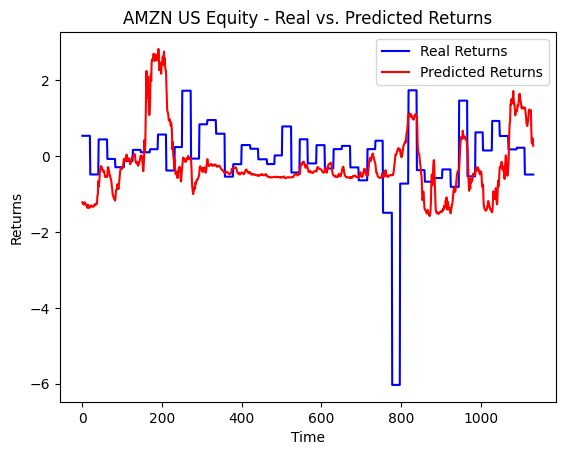

y vs y_pred: (548,) vs (548, 1)


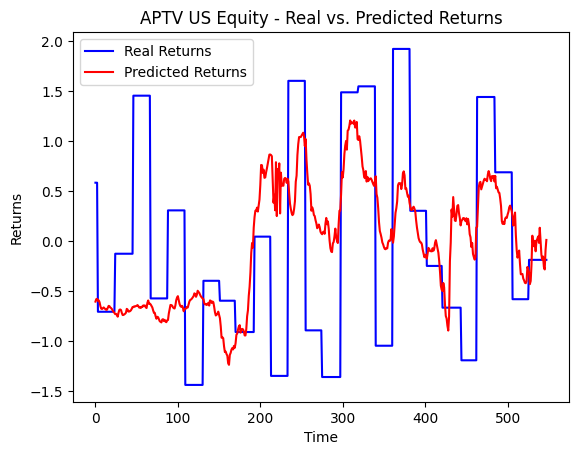

y vs y_pred: (1133,) vs (1133, 1)


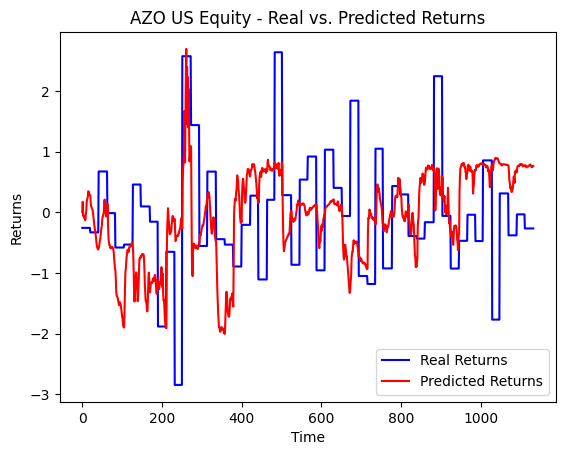

y vs y_pred: (1133,) vs (1133, 1)


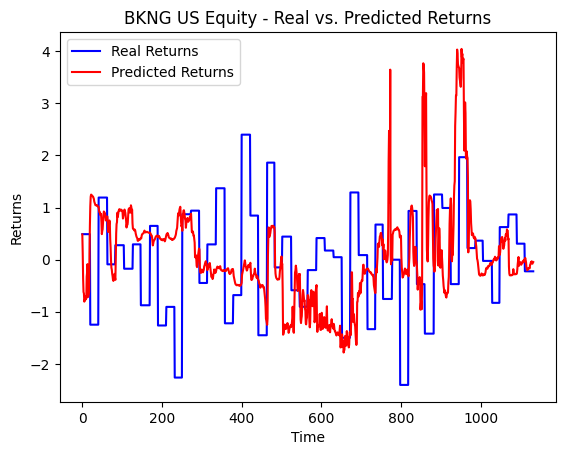

y vs y_pred: (1133,) vs (1133, 1)


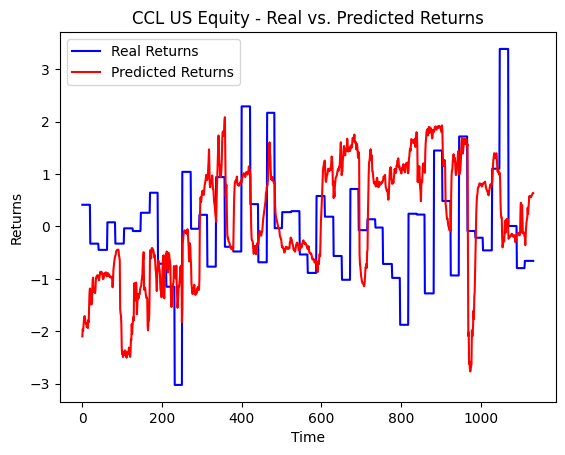

y vs y_pred: (841,) vs (841, 1)


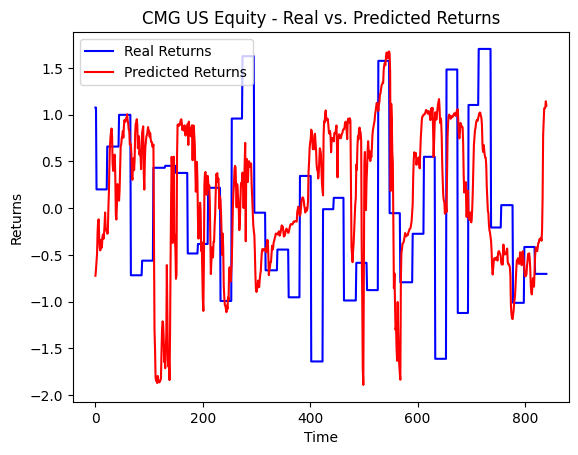

y vs y_pred: (631,) vs (631, 1)


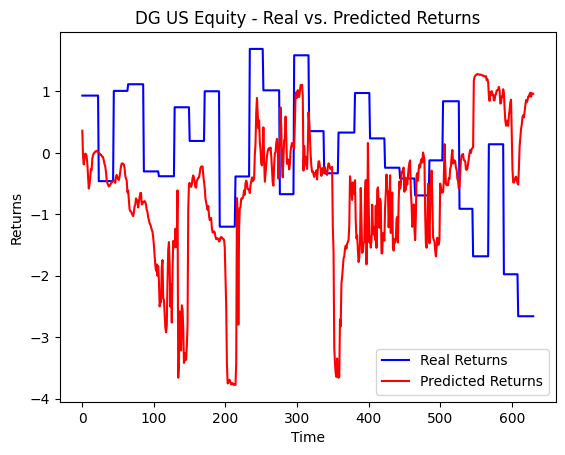

y vs y_pred: (1133,) vs (1133, 1)


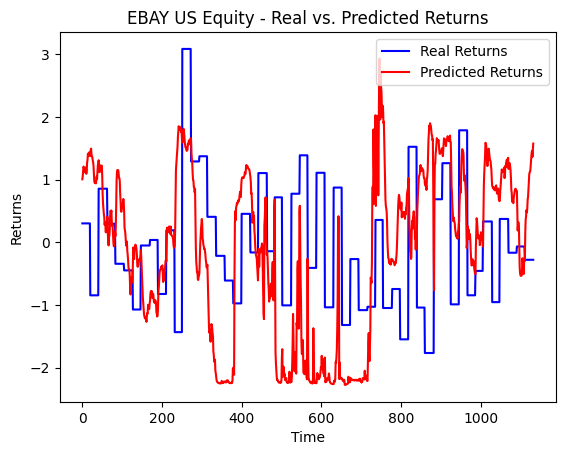

y vs y_pred: (1133,) vs (1133, 1)


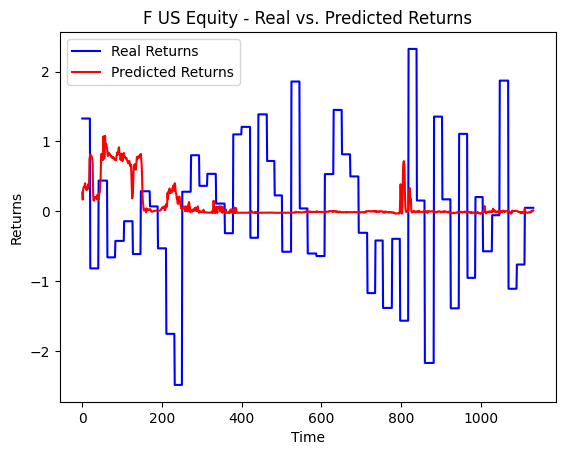

y vs y_pred: (590,) vs (590, 1)


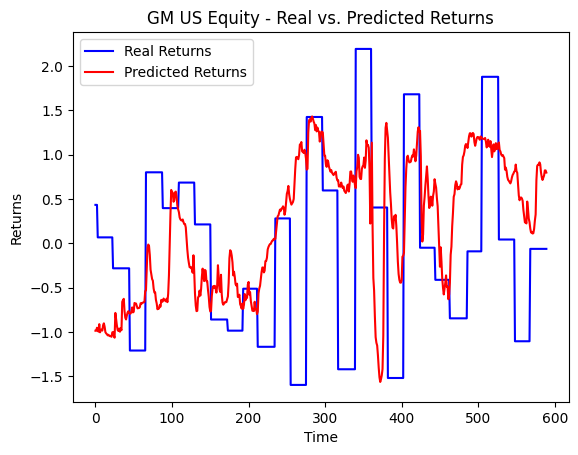

y vs y_pred: (1133,) vs (1133, 1)


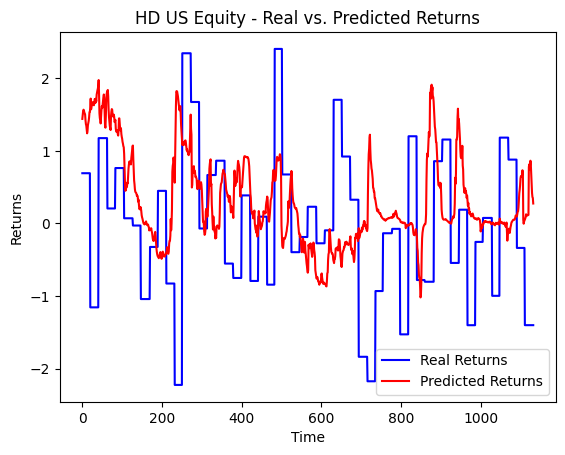

y vs y_pred: (442,) vs (442, 1)


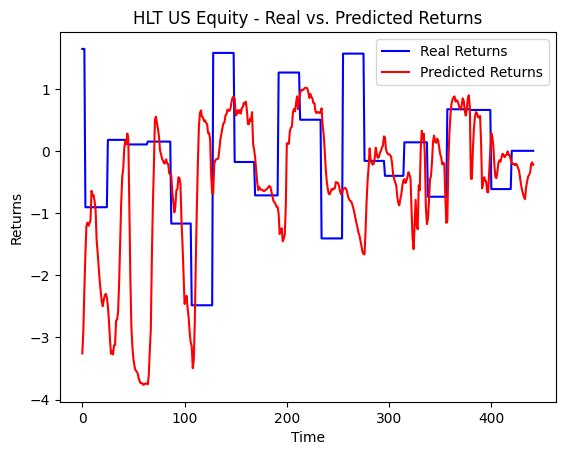

y vs y_pred: (1133,) vs (1133, 1)


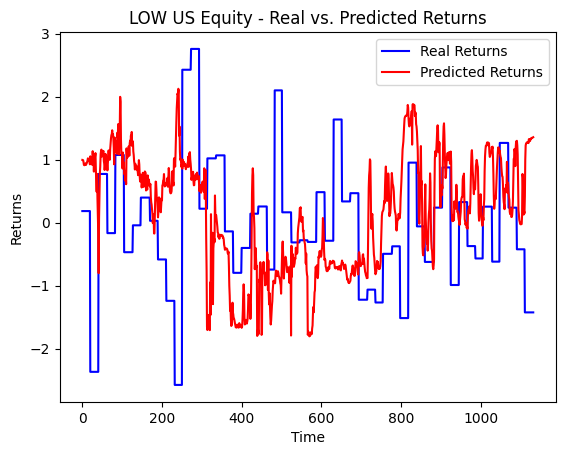

y vs y_pred: (883,) vs (883, 1)


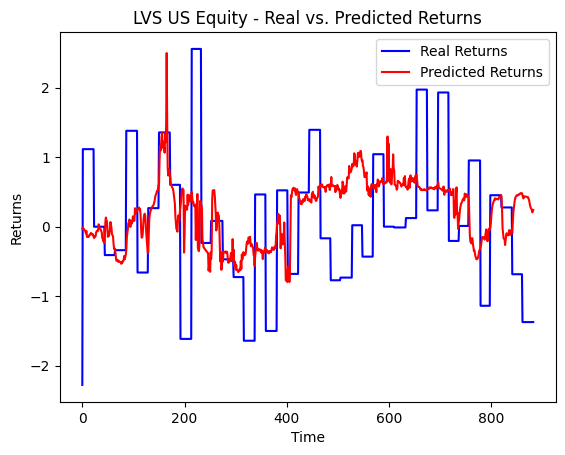

y vs y_pred: (1133,) vs (1133, 1)


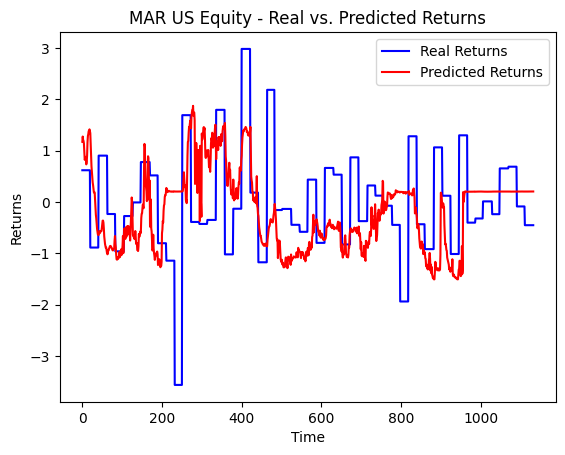

y vs y_pred: (1133,) vs (1133, 1)


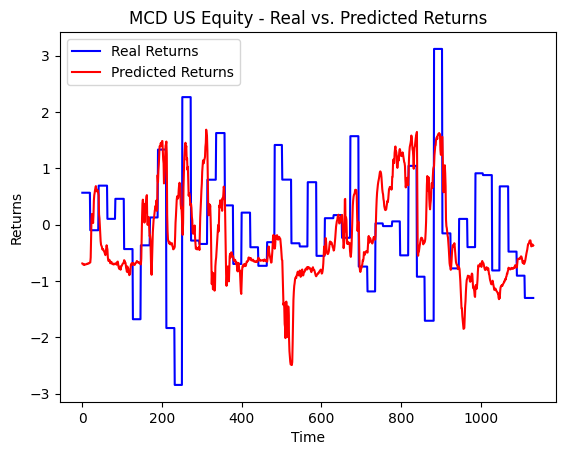

y vs y_pred: (1133,) vs (1133, 1)


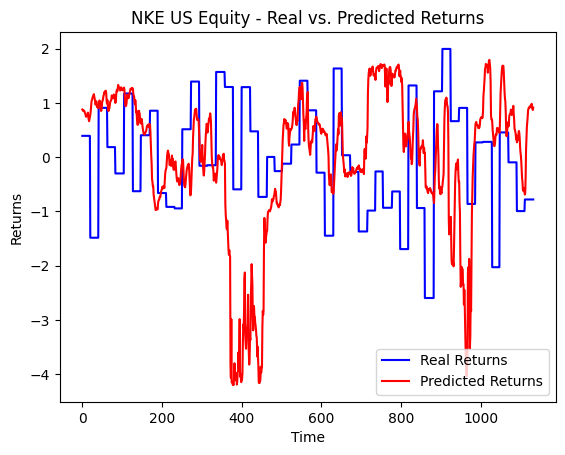

y vs y_pred: (1133,) vs (1133, 1)


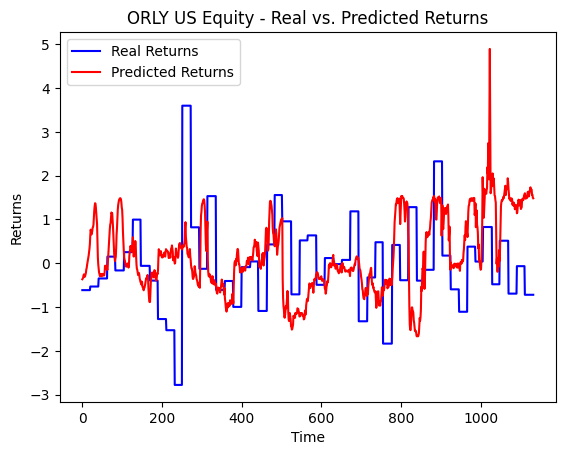

y vs y_pred: (1133,) vs (1133, 1)


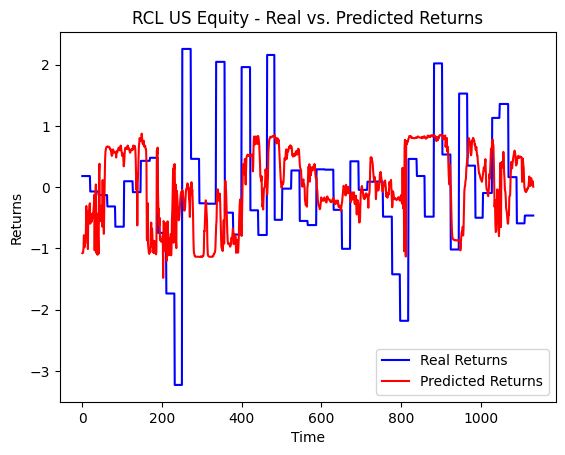

y vs y_pred: (1133,) vs (1133, 1)


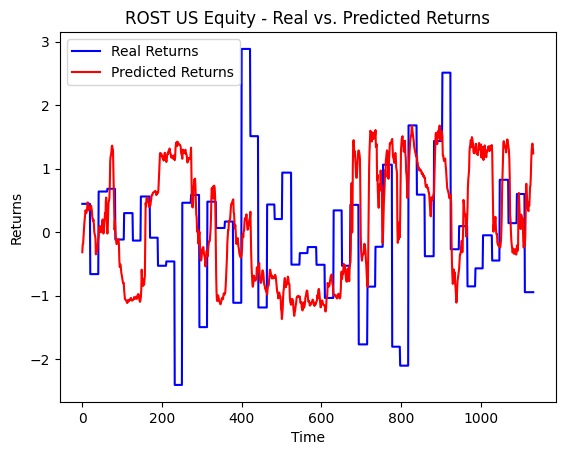

y vs y_pred: (1133,) vs (1133, 1)


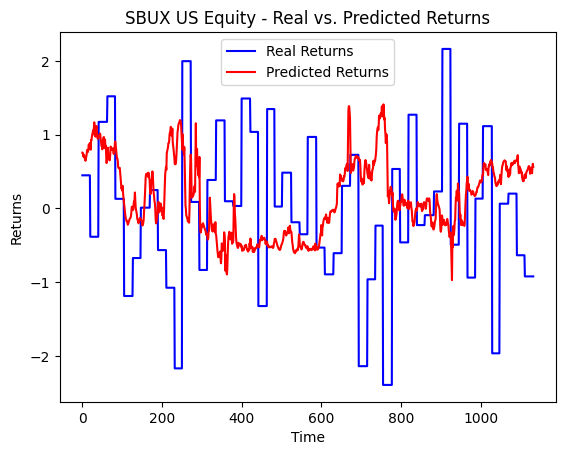

y vs y_pred: (1133,) vs (1133, 1)


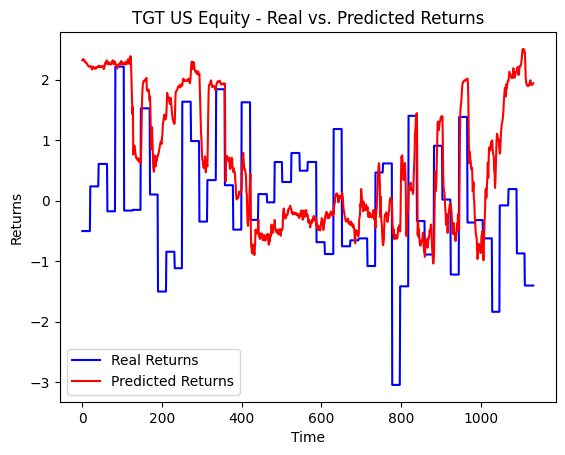

y vs y_pred: (1133,) vs (1133, 1)


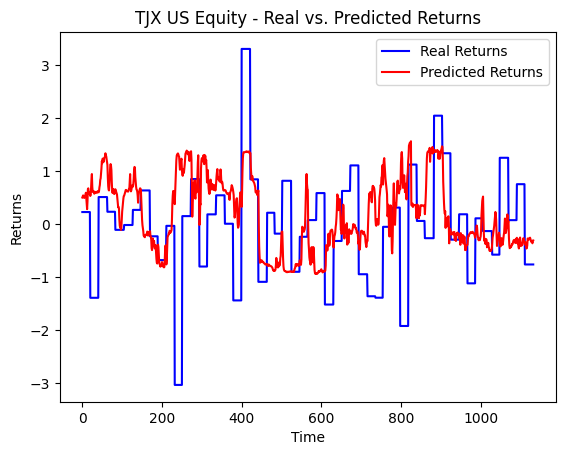

y vs y_pred: (1133,) vs (1133, 1)


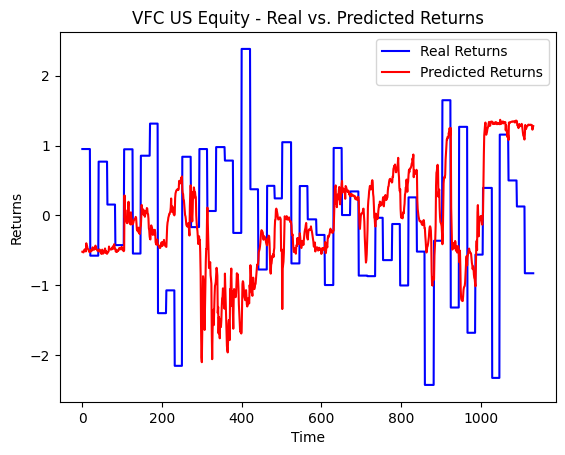

y vs y_pred: (1134,) vs (1134, 1)


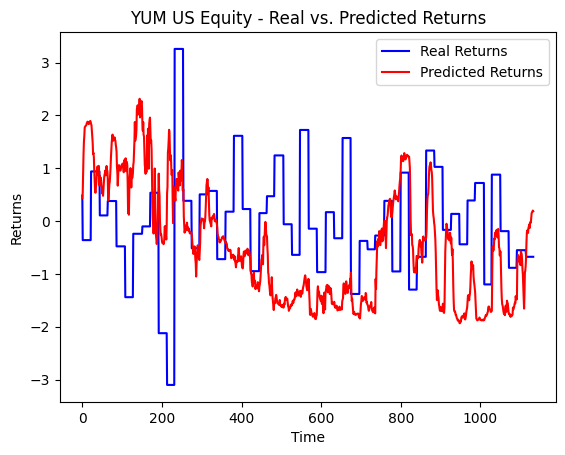

In [ ]:
pred25_next  = analyze(pred25_next, TASK, mode)


In [ ]:
pred25_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.511622   
rmse                                                         1.248365   
mse                                                          1.558415   
y_preds             [[-1.2163408], [-1.2413945], [-1.2412504], [-1...   
y                   [0.5367546248079017, 0.5367546248079017, 0.536...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                            0.14683   
rmse                                                         0.959529   
mse                                                          0.920696   
y_preds             [[-0.60622174], [-0.58144295], [-0.5785721], [...   
y                   [0.5849567495341802, 0.5849567495341802, 0.584...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.154581   
rmse                                                          1.07938   
mse                                                          1.165061   
y_preds             [[0.004193023], [0.17290998], [-0.057641193], ...   
y                   [-0.25638270305473004, -0.25638270305473004, -...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.689978   
rmse                                                         1.321188   
mse                                                          1.745537   
y_preds             [[0.48384708], [0.12584388], [-0.36116204], [-...   
y                   [0.48942929069276814, 0.48942929069276814, 0.4...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.861707   
rmse                                                         1.387891   
mse                                                          1.926241   
y_preds             [[-2.0979383], [-1.9592812], [-1.993983], [-1....   
y                   [0.4145305866984984, 0.4145305866984984, 0.414...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.506637   
rmse                                                         1.065208   
mse                                                          1.134669   
y_preds             [[-0.7231983], [-0.65668154], [-0.57522357], [...   
y                   [1.0767576090255748, 1.0767576090255748, 0.200...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                            -1.7024   
rmse                                                         1.678207   
mse                                                          2.816378   
y_preds             [[0.36125165], [-0.0638254], [-0.1878124], [-0...   
y                   [0.9324965125999684, 0.9324965125999684, 0.932...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -1.476661   
rmse                                                         1.556774   
mse                                                          2.423545   
y_preds             [[1.007608], [1.0574938], [1.1368624], [1.2108...   
y                   [0.3036816543

In [ ]:
save_predictions(pred25_next, signature = 'LSTM_pricecf_2000/next/sep', note = 'epoch7')

### One model all stock

In [ ]:
"""
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96, return_sequences=True),
        Dropout(0.2),
        LSTM(96),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr), loss='mean_squared_error')
    return model


"""
# Initializing the Neural Network based on LSTM
# implemented in this paper: https://www.sciencedirect.com/science/article/pii/S1877050920304865?via%3Dihub
def create_model(inputcol, lr, inputrow = LOOKBACK):
    model = Sequential([
        LSTM(96, return_sequences=True, input_shape=(inputrow, inputcol)),  # input_shape matches the features of X_train
        Dropout(0.2),
        LSTM(32),  # Last LSTM layer should not return sequences
        Dropout(0.2),
        Dense(1, activation='linear')  # Single unit for regression output
    ])
    # Compiling the Neural Network
    model.compile(optimizer = Adam(learning_rate=lr, clipvalue=0.5), loss='mean_squared_error')
    return model


def train_aggregate_model_tune(train_df = None, val_df = None, task = None, lr = None,  N_epoch = 70, batchsize = 64):
  """
  train on all stock data, but used to predict individual stocks.
  data: in stocks25 format
  return: dict pred25 that contains evaluation stats and y_pred vs y for each stock.
          {'stockname':{'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}...}
  """
  X_train = train_df['X_train']
  y_train = train_df['y_train']
  y_train = y_train #*100
  for k,v in train_df.items(): # k is the dataset name: X_train, y_val .etc
    if k == 'X_train':
      single_day_feature_dim = v.shape[2]
      break
  #assert single_day_feature_dim == 90

  stock_model = create_model(single_day_feature_dim, lr)
  es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
  rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
  mcp = ModelCheckpoint(filepath=f'weights_task_{task}_aggregate_model.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
  tb = TensorBoard('logs')
  def lr_scheduler(epoch, lr):
    if epoch < 45:
      return lr
    else:
      return lr * tf.math.exp(-0.1)
  lr_scheduler = LearningRateScheduler(lr_scheduler, verbose=1)
  stock_history = stock_model.fit(X_train, y_train, shuffle=True, epochs=N_epoch, callbacks=[es, rlr, mcp, tb, lr_scheduler], validation_split=0.2, verbose=1, batch_size=batchsize)
  SAVE_PATH = f'/content/gdrive/MyDrive/lazard/models/task_{task}/task_{task}_aggregate_model.h5'
  stock_model.save(SAVE_PATH)

  pred25 = {}
  for key,val in val_df.items():
    print(f'\n\n-------------------{key}--------------------')
    stock_X_val = val["X_val"]
    stock_y_val = val['y_val']
    stock_y_val = stock_y_val #*100

    # predict
    y_preds = stock_model.predict(stock_X_val)
    r_squared_adjusted = r2_score(stock_y_val, y_preds)
    mse = mean_squared_error(stock_y_val, y_preds)
    rmse = np.sqrt(mse)
    pred_org = {'model_path': SAVE_PATH, 'r_squared_adjusted':r_squared_adjusted, 'rmse':rmse,'mse':mse, 'y_preds':y_preds, 'y': stock_y_val}
    pred25[key]=pred_org

  return pred25

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

dfall['X_train'][0].shape

(60, 87)

In [ ]:
TASK = 'next'
if TASK == 'current':
    label_col =  'MONTHLY_RETURN'
    df25 = stock25_cur
    dfall = stock_ONE_curv1
else:
    label_col = 'MONTHLY_RETURN_F1'
    df25 = stock25_next
    dfall = stock_ONE_nextv1
mode = 'agg'

pred25_aggregate_next = train_aggregate_model_tune(train_df = dfall, val_df = df25, lr = 0.005, task = TASK, N_epoch = 2, batchsize = 32)


Epoch 1: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 1/2
2625/2625 [==============================] - ETA: 0s - loss: 0.8804
Epoch 1: val_loss improved from inf to 0.94655, saving model to weights_task_next_aggregate_model.h5
2625/2625 [==============================] - 28s 9ms/step - loss: 0.8804 - val_loss: 0.9466 - lr: 0.0050

Epoch 2: LearningRateScheduler setting learning rate to 0.004999999888241291.
Epoch 2/2
2621/2625 [============================>.] - ETA: 0s - loss: 0.6450
Epoch 2: val_loss did not improve from 0.94655
2625/2625 [==============================] - 22s 8ms/step - loss: 0.6449 - val_loss: 1.0587 - lr: 0.0050


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




-------------------AMZN US Equity--------------------
36/36 [==============================] - 1s 4ms/step


-------------------APTV US Equity--------------------
18/18 [==============================] - 0s 4ms/step


-------------------AZO US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------BKNG US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------CCL US Equity--------------------
36/36 [==============================] - 0s 4ms/step


-------------------CMG US Equity--------------------
27/27 [==============================] - 0s 4ms/step


-------------------DG US Equity--------------------
20/20 [==============================] - 0s 4ms/step


-------------------EBAY US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------F US Equity--------------------
36/36 [==============================] - 0s 3ms/step


-------------------GM US 

y vs y_pred: (1133,) vs (1133, 1)


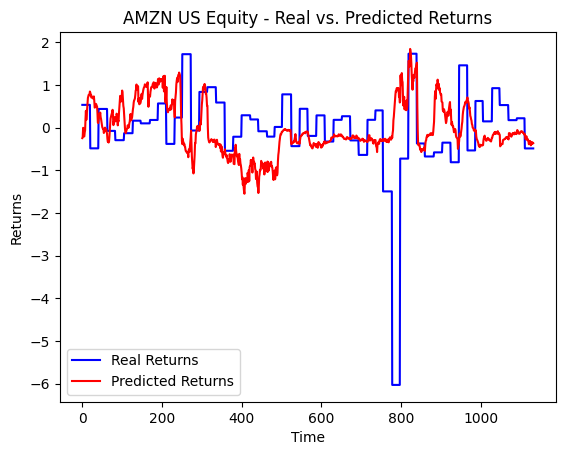

y vs y_pred: (548,) vs (548, 1)


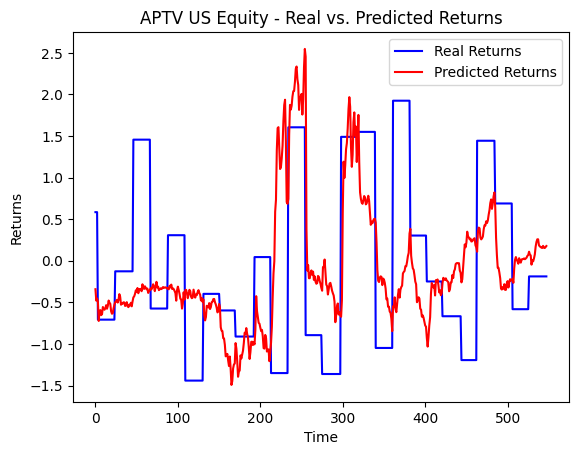

y vs y_pred: (1133,) vs (1133, 1)


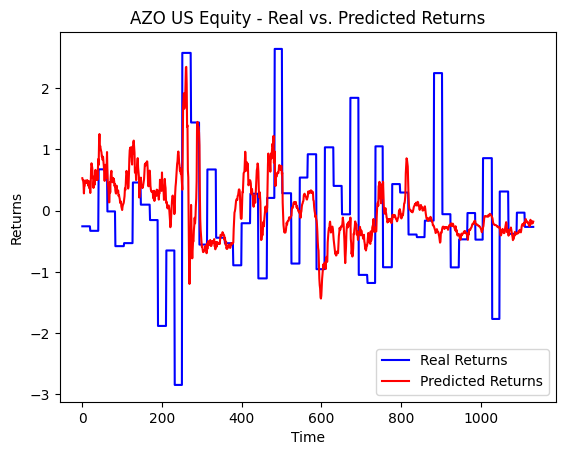

y vs y_pred: (1133,) vs (1133, 1)


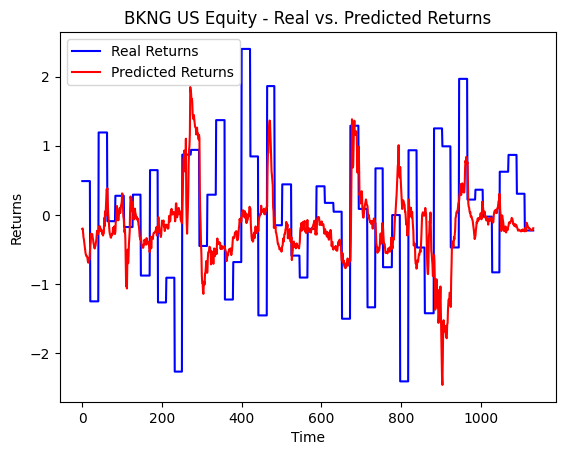

y vs y_pred: (1133,) vs (1133, 1)


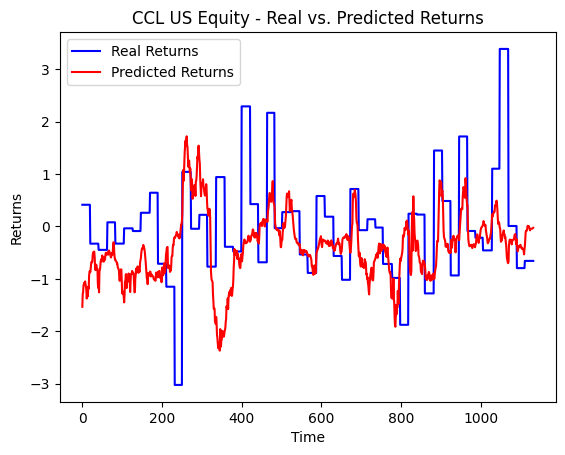

y vs y_pred: (841,) vs (841, 1)


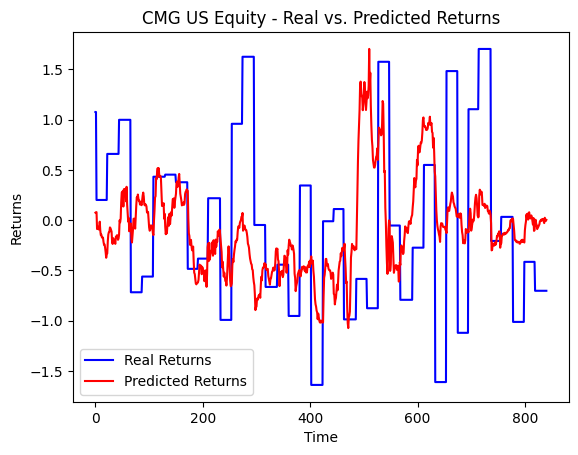

y vs y_pred: (631,) vs (631, 1)


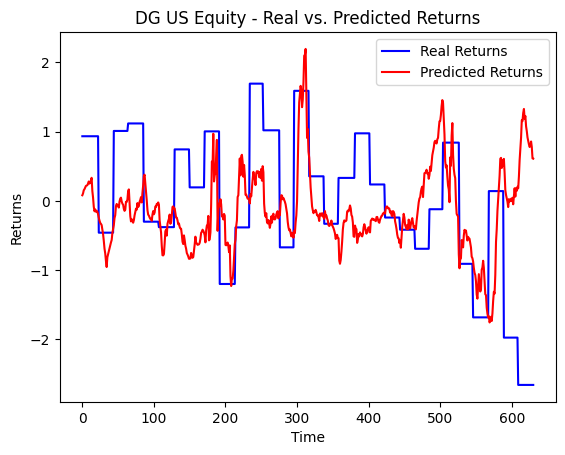

y vs y_pred: (1133,) vs (1133, 1)


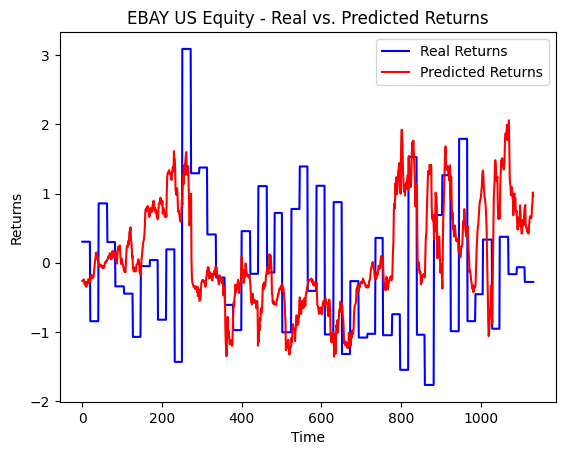

y vs y_pred: (1133,) vs (1133, 1)


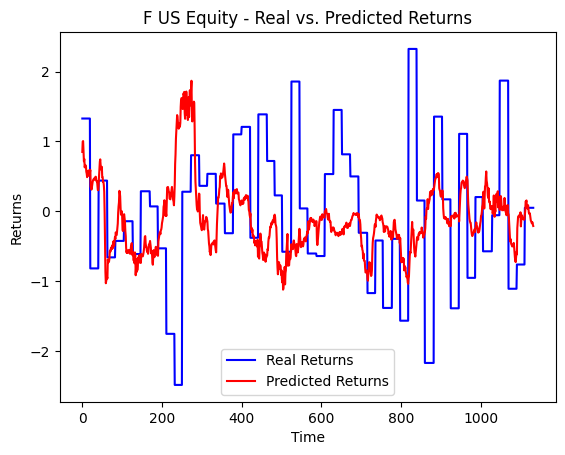

y vs y_pred: (590,) vs (590, 1)


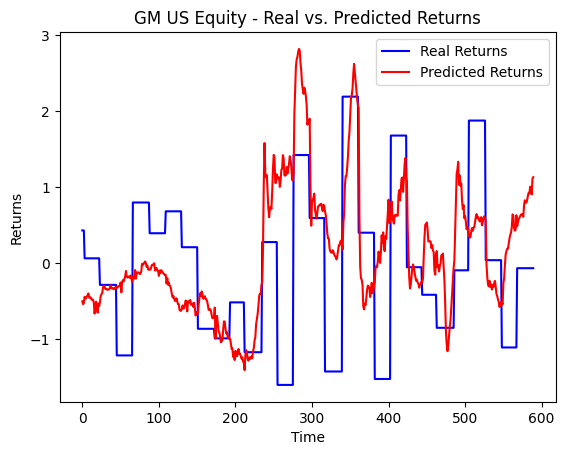

y vs y_pred: (1133,) vs (1133, 1)


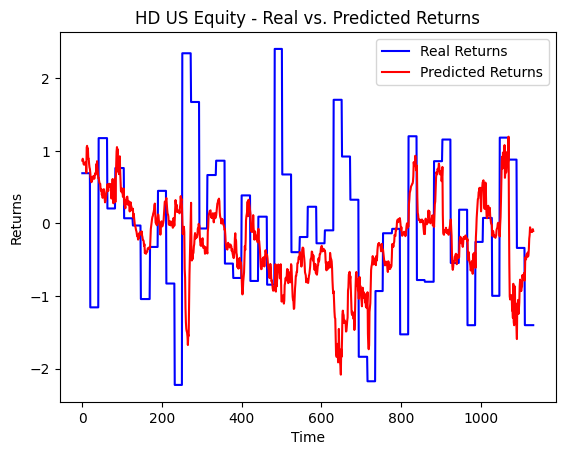

y vs y_pred: (442,) vs (442, 1)


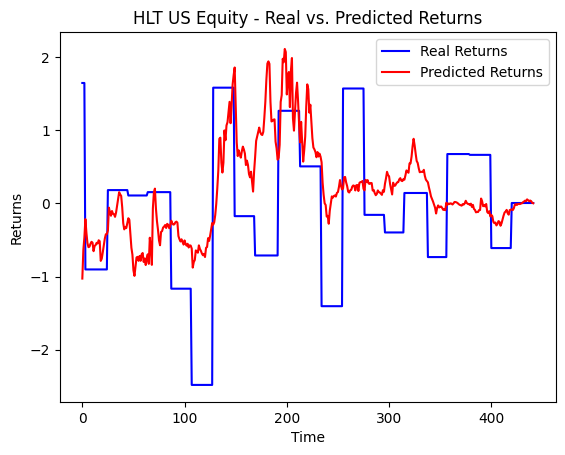

y vs y_pred: (1133,) vs (1133, 1)


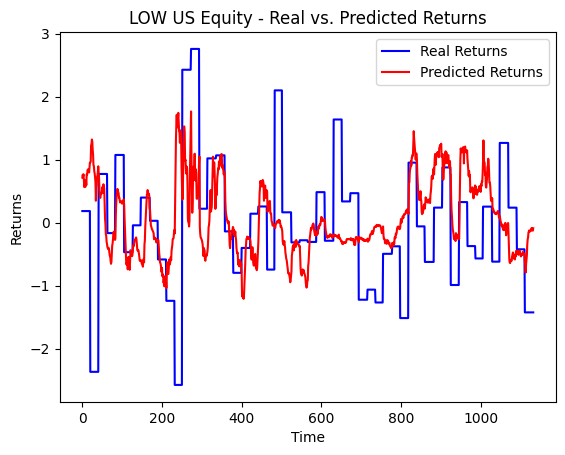

y vs y_pred: (883,) vs (883, 1)


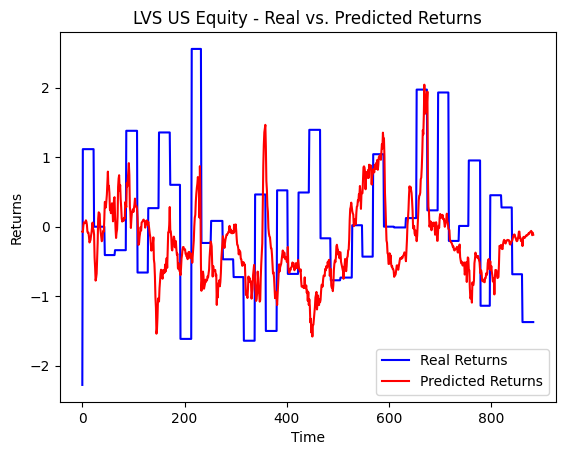

y vs y_pred: (1133,) vs (1133, 1)


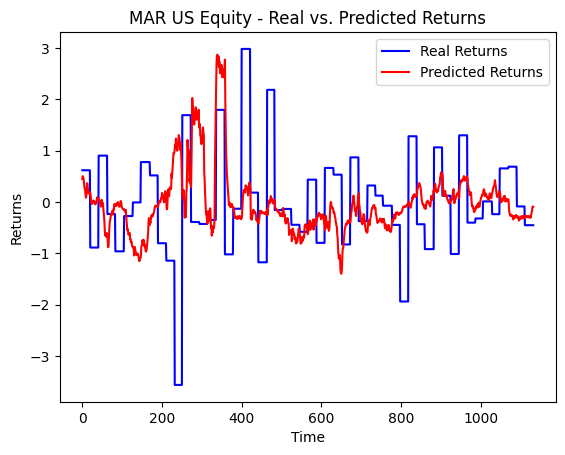

y vs y_pred: (1133,) vs (1133, 1)


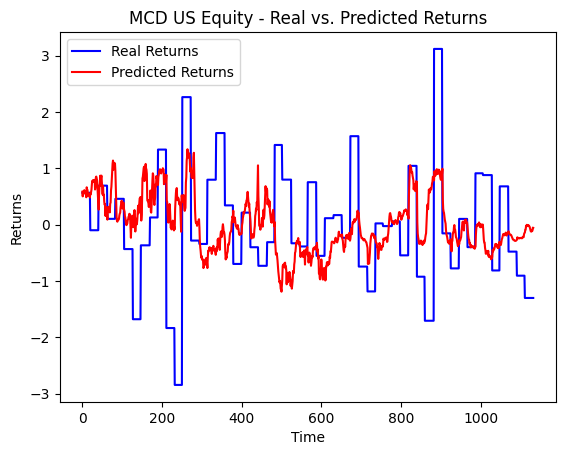

y vs y_pred: (1133,) vs (1133, 1)


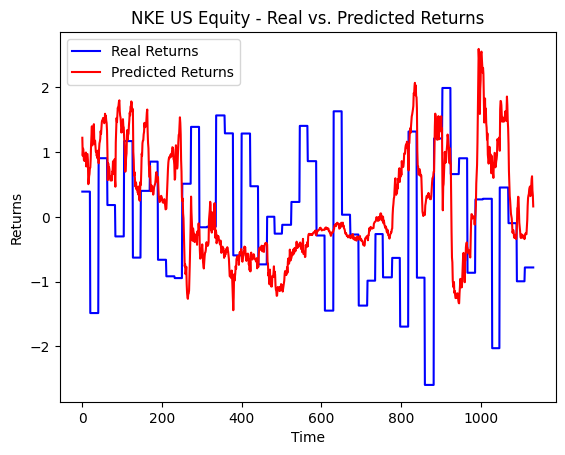

y vs y_pred: (1133,) vs (1133, 1)


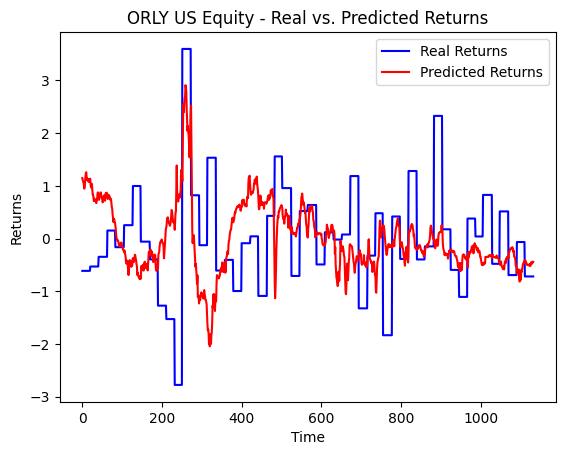

y vs y_pred: (1133,) vs (1133, 1)


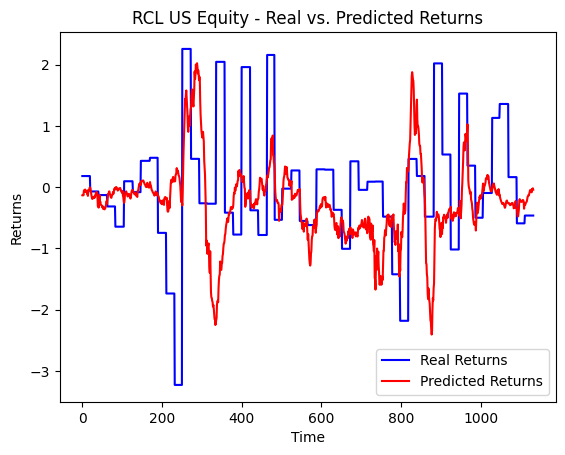

y vs y_pred: (1133,) vs (1133, 1)


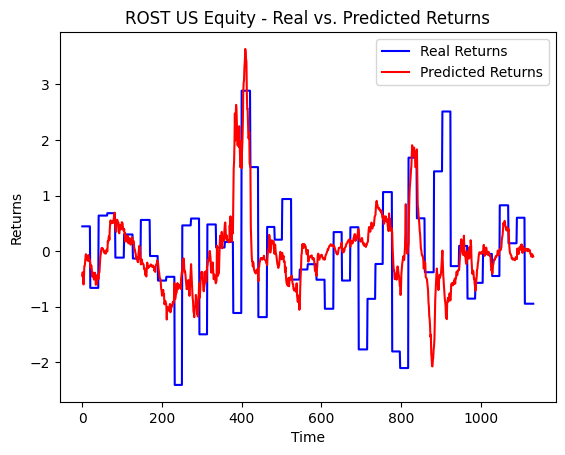

y vs y_pred: (1133,) vs (1133, 1)


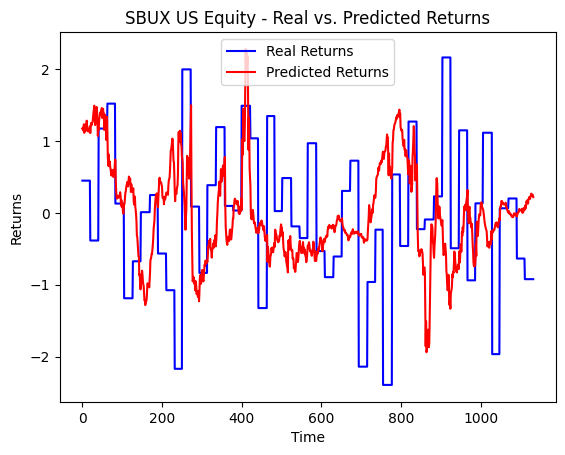

y vs y_pred: (1133,) vs (1133, 1)


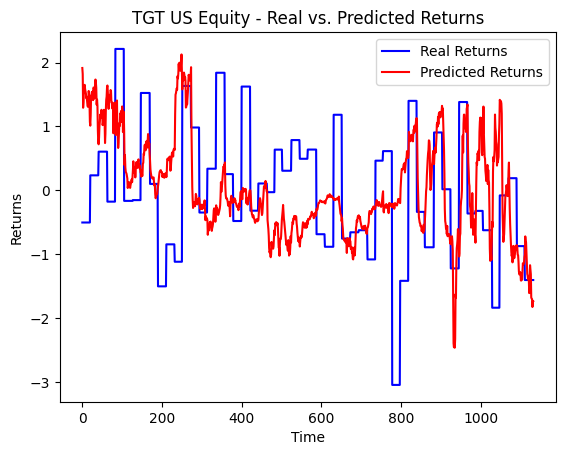

y vs y_pred: (1133,) vs (1133, 1)


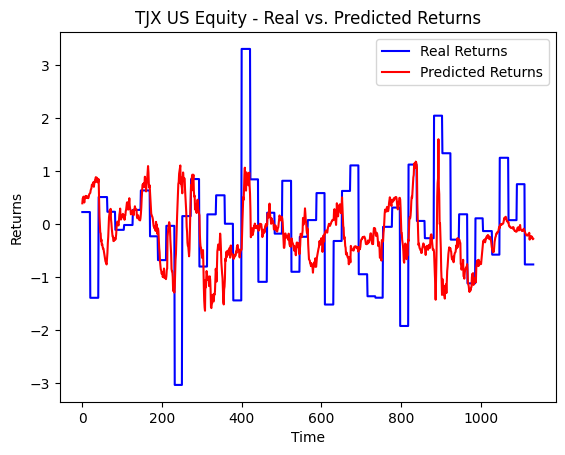

y vs y_pred: (1133,) vs (1133, 1)


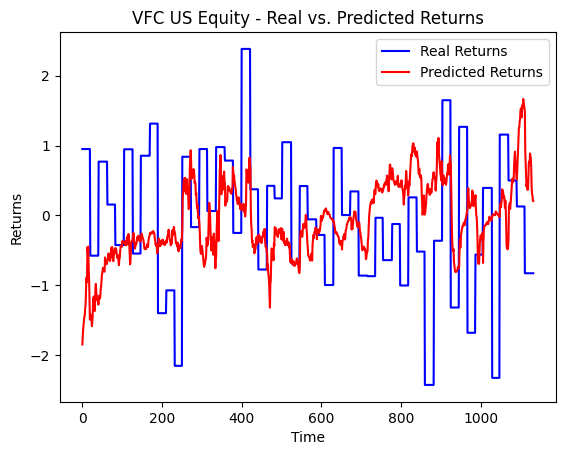

y vs y_pred: (1134,) vs (1134, 1)


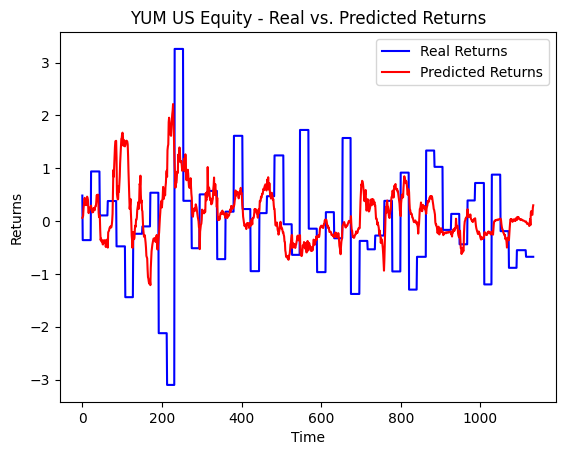

In [ ]:
pred25_aggregate_next  = analyze(pred25_aggregate_next, TASK, mode)


In [ ]:
pred25_aggregate_next

AMZN US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.389609   
rmse                                                         1.196923   
mse                                                          1.432625   
y_preds             [[-0.24332373], [-0.2102807], [-0.001548009], ...   
y                   [0.5367546248079017, 0.5367546248079017, 0.536...   

                                                       APTV US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                            0.07391   
rmse                                                         0.999693   
mse                                                          0.999386   
y_preds             [[-0.34185272], [-0.4789465], [-0.45340928], [...   
y                   [0.5849567495341802, 0.5849567495341802, 0.584...   

                                                        AZO US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.118188   
rmse                                                         1.062232   
mse                                                          1.128337   
y_preds             [[0.52859956], [0.49801242], [0.49952197], [0....   
y                   [-0.25638270305473004, -0.25638270305473004, -...   

                                                       BKNG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.116528   
rmse                                                         1.073887   
mse                                                          1.153234   
y_preds             [[-0.20042379], [-0.19434735], [-0.258671], [-...   
y                   [0.48942929069276814, 0.48942929069276814, 0.4...   

                                                        CCL US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.265854   
rmse                                                         1.144436   
mse                                                          1.309734   
y_preds             [[-1.5335991], [-1.2876935], [-1.2594749], [-1...   
y                   [0.4145305866984984, 0.4145305866984984, 0.414...   

                                                        CMG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.042697   
rmse                                                         0.886154   
mse                                                          0.785269   
y_preds             [[0.07470234], [0.078764796], [0.07986146], [-...   
y                   [1.0767576090255748, 1.0767576090255748, 0.200...   

                                                         DG US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.192727   
rmse                                                         1.114914   
mse                                                          1.243033   
y_preds             [[0.079829305], [0.10578266], [0.1523802], [0....   
y                   [0.9324965125999684, 0.9324965125999684, 0.932...   

                                                       EBAY US Equity  \
model_path          /content/gdrive/MyDrive/lazard/models/task_nex...   
r_squared_adjusted                                          -0.497041   
rmse                                                         1.210345   
mse                                                          1.464935   
y_preds             [[-0.26323324], [-0.25734785], [-0.2579338], [...   
y                   [0.3036816543

In [ ]:
save_predictions(pred25_aggregate_next, signature = 'LSTM_pricecf_2000/next/agg', note = 'shallow_epoch2')